# K-means Clustering

> 10185101210 陈俊潼
>
> East China Normal University

K-means 聚类算法的演示。

首先定义一个方便打印状态的日志类：

In [39]:
from datetime import datetime
import os
# Logger and colors
class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

class logger:
    @staticmethod
    def __log(msg, level, color=bcolors.ENDC):
        date = datetime.today().strftime("%Y-%m-%d %H:%M:%S")
        with open("log.log", "a+") as f:
            f.write("<{} {}>: {}\n".format(date, level, msg))
        if True:
            print("<{} {}>: {}".format(date, level, msg))
        else:
            print("<{} {}>: {}".format(date, level, color + bcolors.BOLD + msg + bcolors.ENDC))

    @staticmethod
    def info(msg):
        logger.__log(msg, "INFO", bcolors.OKBLUE)

    @staticmethod
    def warn(msg):
        logger.__log(msg, "WARN", bcolors.HEADER)

    @staticmethod
    def error(msg):
        logger.__log(msg, "ERROR", bcolors.FAIL)

## 初始化

初始化参数，并导入必要的库。

聚类所需的数据存储在 data.txt 中，每一行为坐标的 x 和 y 值，以逗号隔开。

In [87]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# HiDPI Support
mpl.rcParams['figure.dpi'] = 180

# Stop condition
MAX_EPOCHS = 20

K_MIN = 2
K_MAX = 5

data = np.empty((0, 2), np.double)

def load_data(randomize=False):
    global data
    data = np.empty((0, 2), np.double)
    if not randomize:
        with open("data.txt", "r") as f:
            data = np.empty((0, 2), float)
            lines = f.readlines()
            for oneLine in lines:
                (x, y) = oneLine.replace("\n", "").split(" ")
                data = np.append(data, np.array([[float(x), float(y)]]), axis=0)
    else:
        for i in range(100):
            data = np.append(data, np.array(np.random.random((1,2)) * 2), axis=0)
        for i in range(100):
            data = np.append(data, np.array(np.random.random((1,2))), axis=0)
        for i in range(100):
            data = np.append(data, np.array(np.random.random((1,2)) * 3), axis=0)

load_data(randomize=False)

定义初始化 k 个核的函数、用来评估聚类结果的 SSE 计算函数和绘制当前聚类情况的函数：

In [84]:
def init_centroids(k):
    row_rand_array = np.arange(data.shape[0])
    np.random.shuffle(row_rand_array)
    centroids = data[row_rand_array[0:k]]
    return centroids


def get_sse(clusters, centroids):
    sum = 0
    for i in range(len(clusters)):
        sum = sum + np.sqrt(np.sum(np.square(clusters[i] - centroids[i])))
    return sum / len(clusters)


def plot(clusters, centroids, k, e):
    plt.figure(figsize=(10, 3.5))
    plt.grid()
    for i in range(k):
        plt.title("K = {}, epoch = {}".format(k, e))
        plt.scatter(clusters[i][:,0], clusters[i][:,1])
        plt.scatter(centroids[:,0], centroids[:,1],marker='o', s=80, facecolors='r', edgecolors='#000000')
    plt.savefig("image/output_k={}_epoch={}.jpg".format(k, e))
    plt.show()

首先对于 K = 2 的情况，随机生成两个点作为聚类中心，用红色来标记聚类中心。

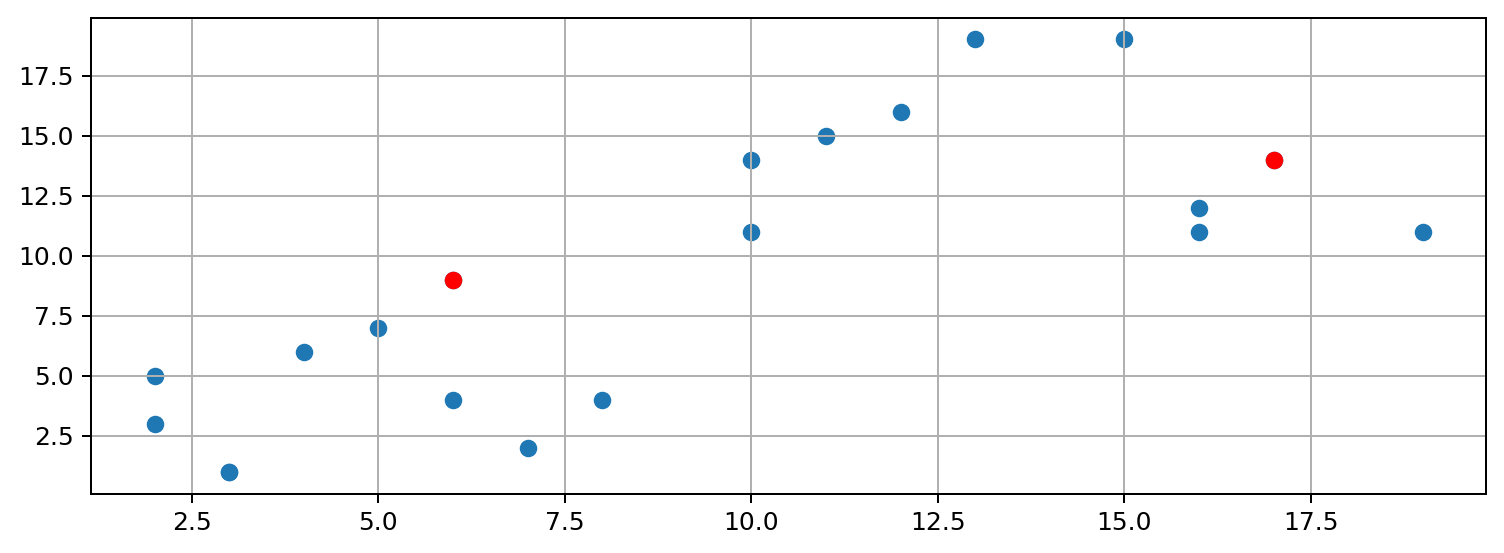

In [90]:
centroids = init_centroids(2)
original_centroids = centroids
plt.figure(figsize=(10, 3.5))
plt.grid()
plt.scatter(data[:, 0], data[:, 1])
plt.scatter(centroids[:, 0], centroids[:, 1], c='r')
plt.savefig("image/output_init.jpg")
plt.show()

接下来开始定义 `kmeans()`。

每次迭代一次计算各个点与核之间的距离，然后根据各个簇更新新的核：

$ \mathbf{c}_{j}=\frac{1}{\left|G_{j}\right|} \sum_{\mathbf{x}_{i} \in G_{j}} \mathbf{x}_{i} $

如果迭代次数达到了 `MAX_EPOCHS` 或者两次更新的聚类中心之间的欧氏距离小于 0.5，则会退出迭代。函数的返回值为最终计算出的 SSE。

<2021-01-02 19:56:29 INFO>: K-Means started. K = 2, MAX_EPOCHS = 10
<2021-01-02 19:56:30 INFO>: [EPOCH 0] Centroid updated: [[13.9 14.2] [ 4.6  4.2]]
<2021-01-02 19:56:30 INFO>: [EPOCH 0] Current SSE: 11.654674875992491; Centroid offset: 5.123475382979798
<2021-01-02 19:56:30 INFO>: [EPOCH 1] Centroids are almost stable. Iterating stopped.
<2021-01-02 19:56:30 INFO>: [EPOCH 1] Current SSE: 11.654674875992491; Centroid offset: 0.0
<2021-01-02 19:56:30 INFO>: Centroid coordinates: [[13.9 14.2] [ 4.6  4.2]]


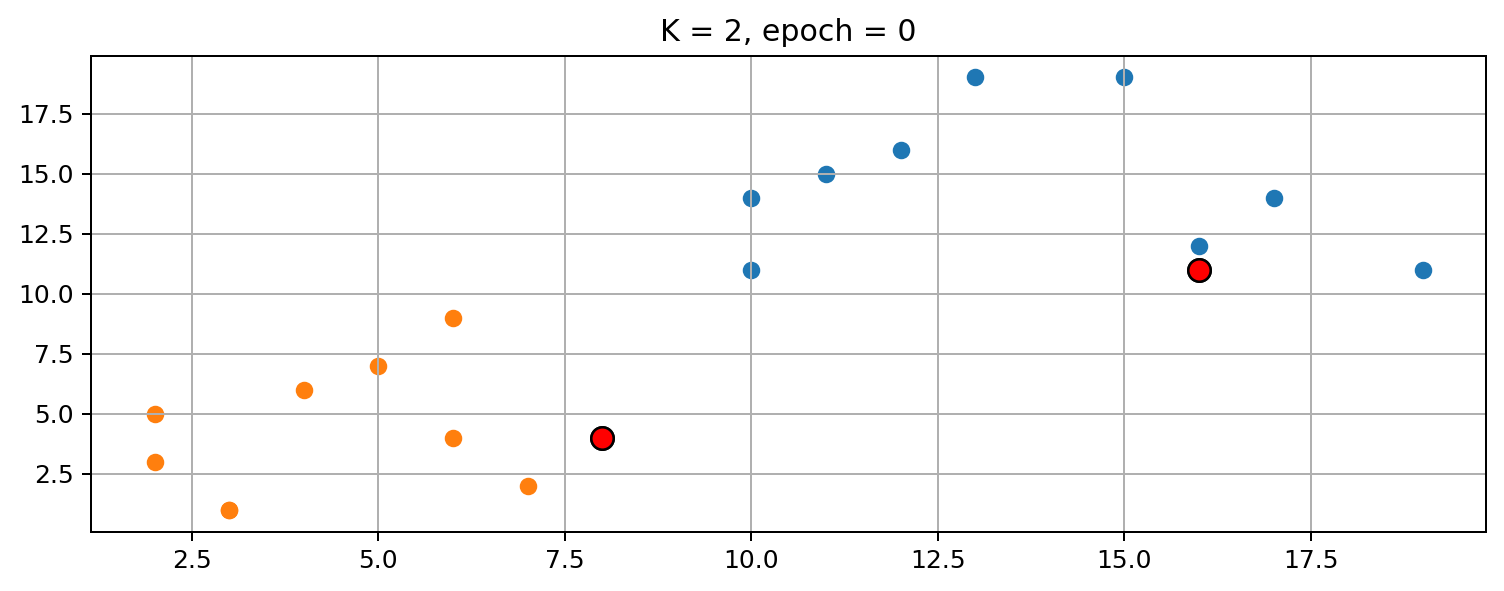

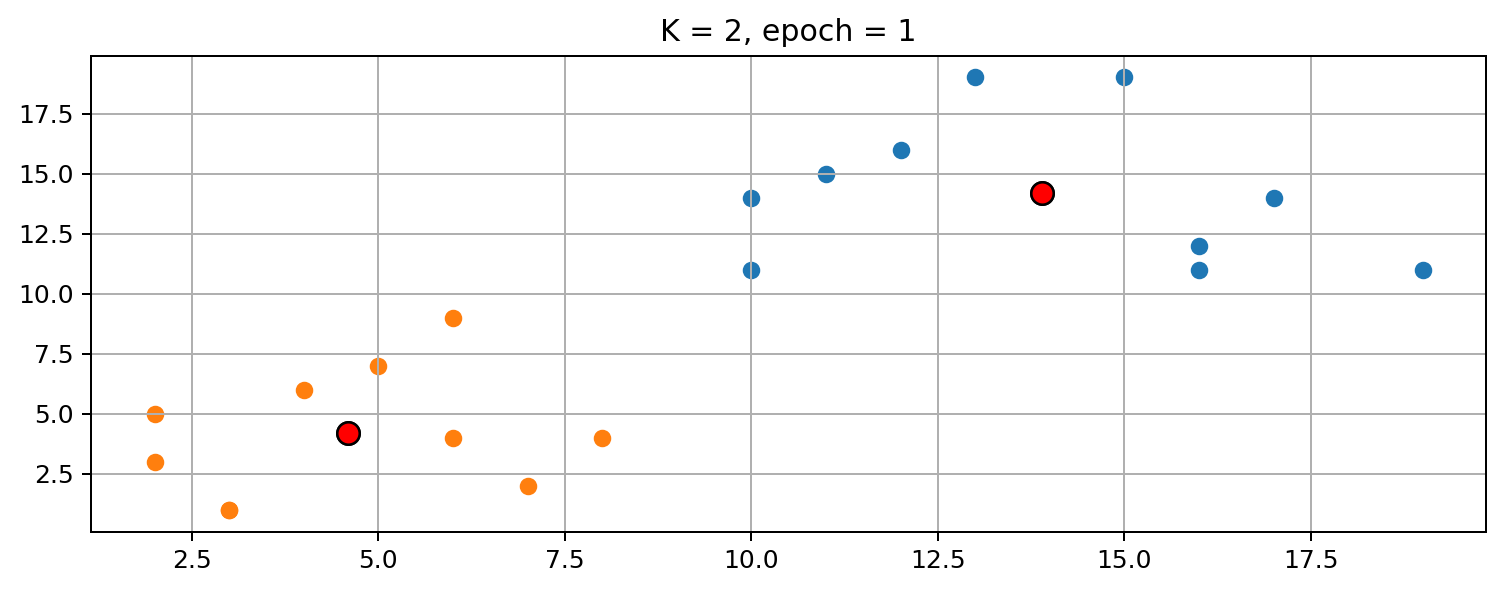

11.654674875992491

In [78]:
def kmeans(k):
    logger.info("K-Means started. K = {}, MAX_EPOCHS = {}".format(k, MAX_EPOCHS))
    clusters = [np.empty((0, 2), np.double) for i in range(k)]
    global centroids
    for e in range(MAX_EPOCHS):
        distances = np.empty((0, data.shape[0]), np.double)
        # Calculating the distance between centroids and each point
        for i in range(k):
            centroid = centroids[i,:]
            clusters = [np.empty((0, 2), np.double) for i in range(k)] ## K
            dis = np.sqrt((data[:,0] - centroid[0])**2 + (data[:,1] - centroid[1])**2)
            distances = np.vstack([distances, dis])

        # Clustering
        closest_centroid = np.argmin(distances, axis=0)
        for j in range(data.shape[0]):
            clusters[closest_centroid[j]] = np.vstack([clusters[closest_centroid[j]], data[j]])

        # Plotting
        plot(clusters, centroids, k, e)

        # Update centroids
        centroids_new = np.array(centroids)
        for i in range(k):
            centroids_new[i] = np.average(clusters[i], axis=0)

        # Check distance
        centroids_distance = np.sqrt(np.sum(np.square(centroids_new - centroids)))
        if centroids_distance < 0.05:
            logger.info("[EPOCH {}] Centroids are almost stable. Iterating stopped.".format(e))
            logger.info("[EPOCH {}] Current SSE: {}; Centroid offset: {}".format(e, get_sse(clusters, centroids), centroids_distance))
            break
        else:
            centroids = centroids_new
            logger.info("[EPOCH {}] Centroid updated: "
                        .format(e) + np.array2string(centroids, precision=2).replace("\n", ""))
            logger.info("[EPOCH {}] Current SSE: {}; Centroid offset: {}".format(e, get_sse(clusters, centroids), centroids_distance))
    logger.info("Centroid coordinates: {}".format(np.array2string(centroids, precision=2).replace("\n", "")))
    return get_sse(clusters, centroids)

centroids = init_centroids(2)
kmeans(2)

记下来将 k 从 2 逐渐增大到 5，并使用相同的聚类中心，并绘制出 SSE 随 K 的变化。

<2021-01-02 19:56:45 INFO>: K-Means started. K = 2, MAX_EPOCHS = 10
<2021-01-02 19:56:45 INFO>: [EPOCH 0] Centroid updated: [[ 4.6  4.2] [13.9 14.2]]
<2021-01-02 19:56:45 INFO>: [EPOCH 0] Current SSE: 11.654674875992491; Centroid offset: 4.695742752749558
<2021-01-02 19:56:46 INFO>: [EPOCH 1] Centroids are almost stable. Iterating stopped.
<2021-01-02 19:56:46 INFO>: [EPOCH 1] Current SSE: 11.654674875992491; Centroid offset: 0.0
<2021-01-02 19:56:46 INFO>: Centroid coordinates: [[ 4.6  4.2] [13.9 14.2]]
<2021-01-02 19:56:46 INFO>: K-Means started. K = 3, MAX_EPOCHS = 10
<2021-01-02 19:56:46 INFO>: [EPOCH 0] Centroid updated: [[17.   12.  ] [ 4.6   4.2 ] [11.83 15.67]]
<2021-01-02 19:56:46 INFO>: [EPOCH 0] Current SSE: 7.232632038258262; Centroid offset: 4.2354325503883175
<2021-01-02 19:56:46 INFO>: [EPOCH 1] Centroids are almost stable. Iterating stopped.
<2021-01-02 19:56:46 INFO>: [EPOCH 1] Current SSE: 7.232632038258262; Centroid offset: 0.0
<2021-01-02 19:56:46 INFO>: Centroid co

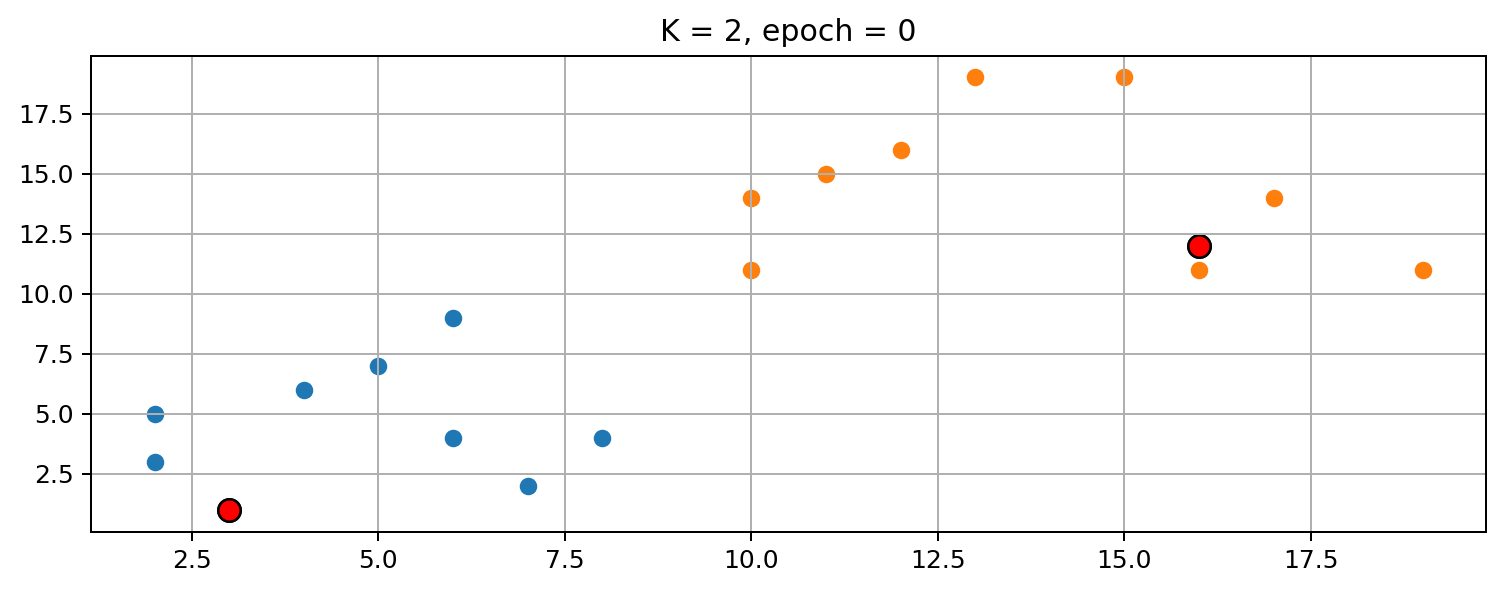

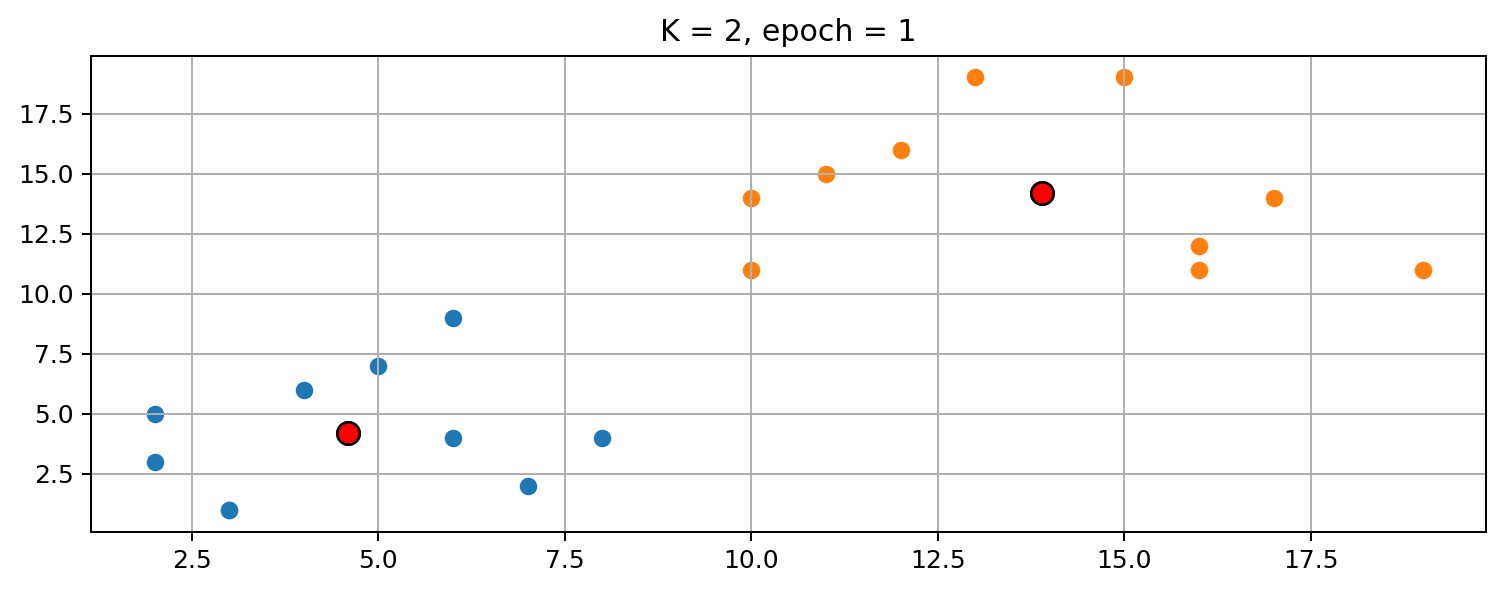

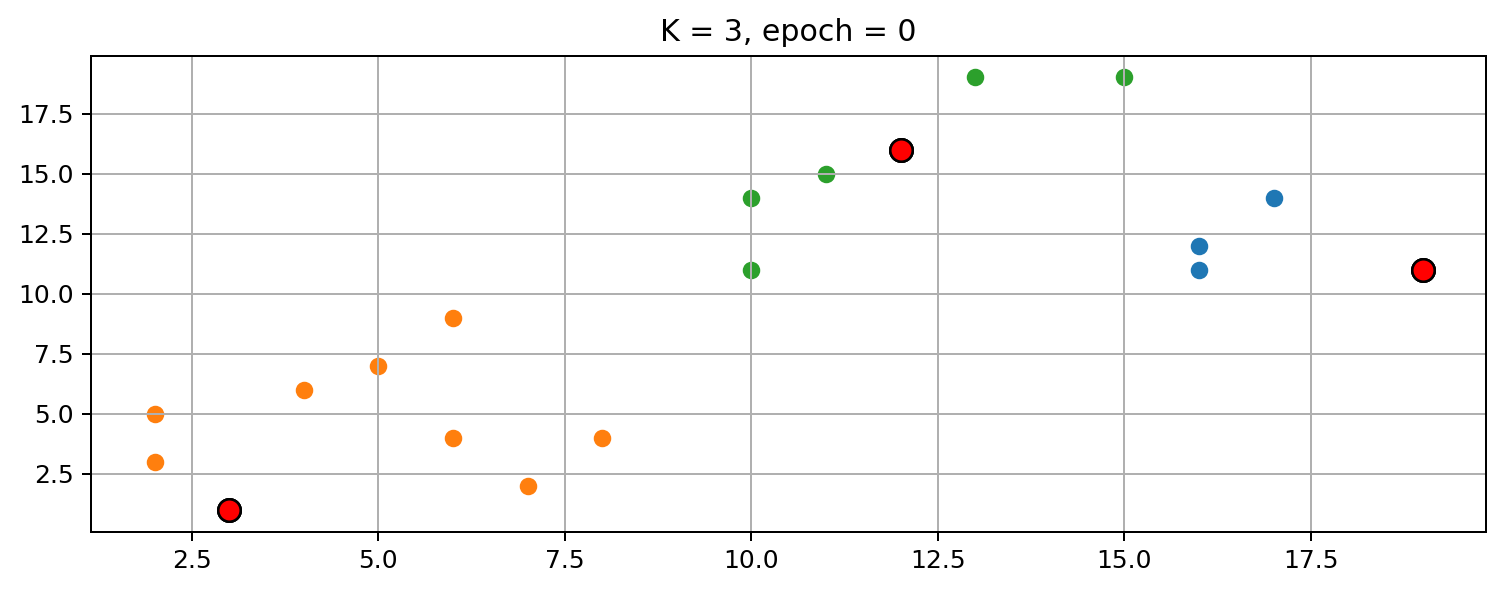

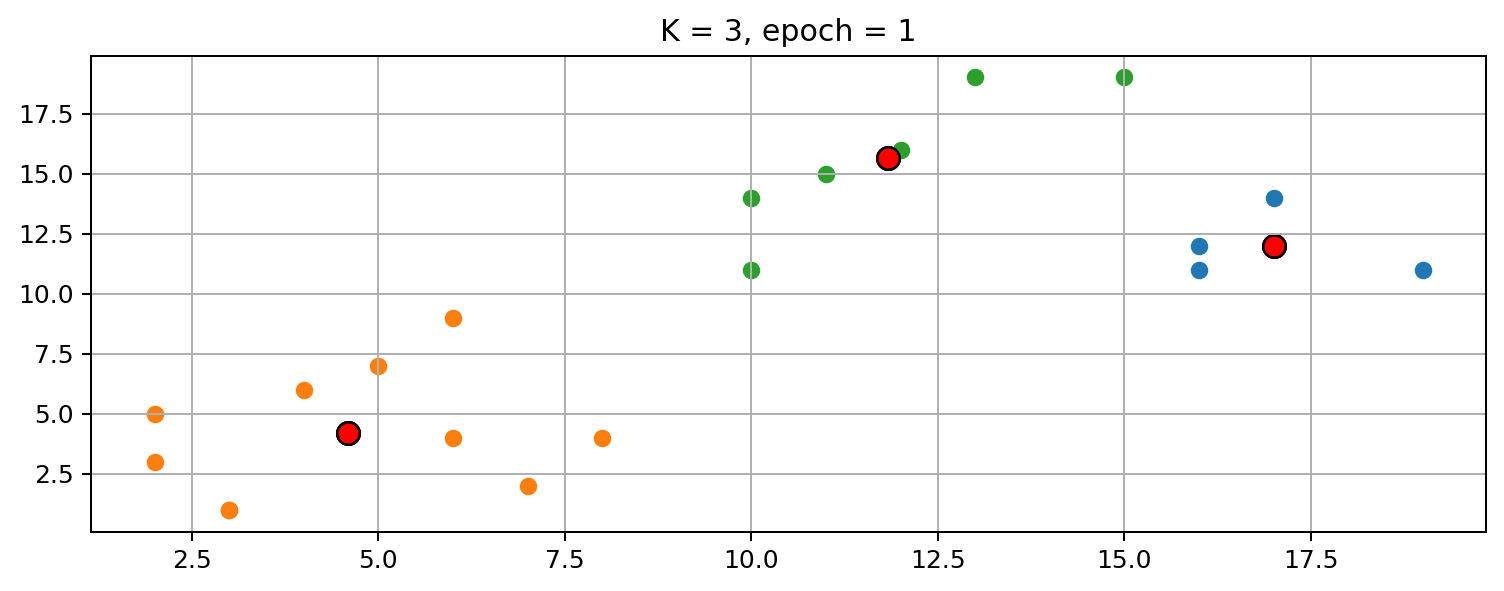

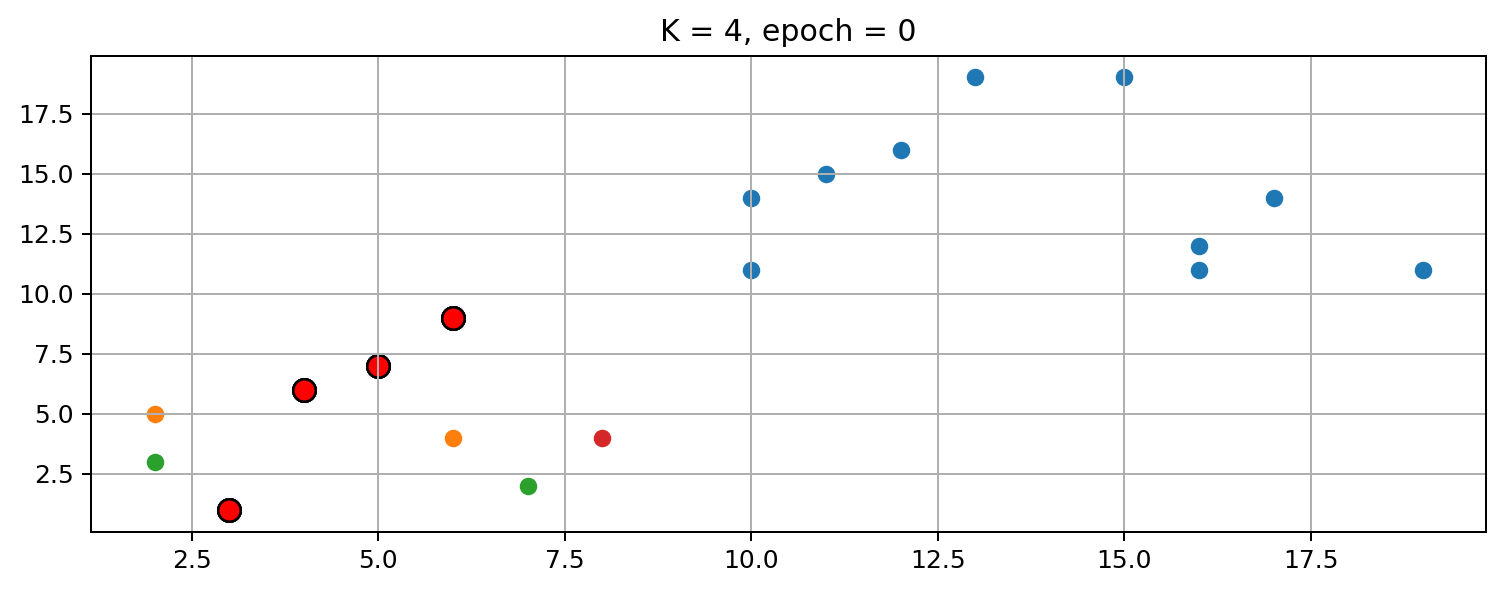

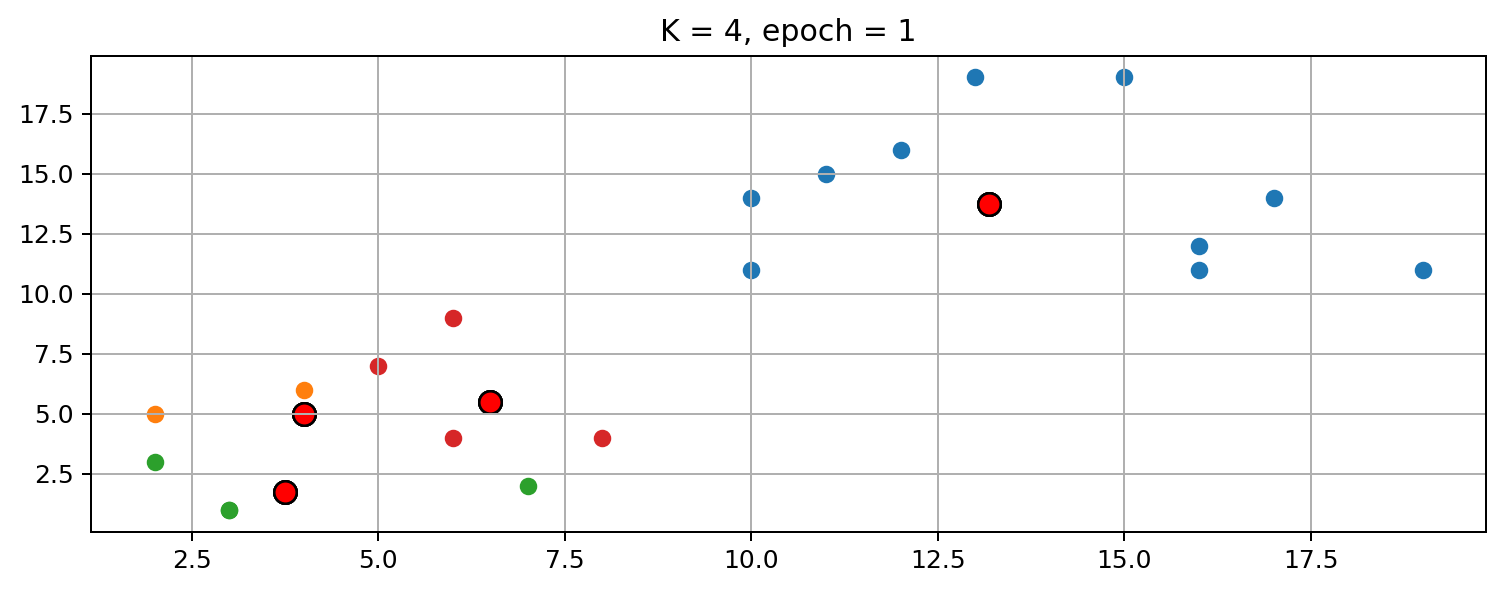

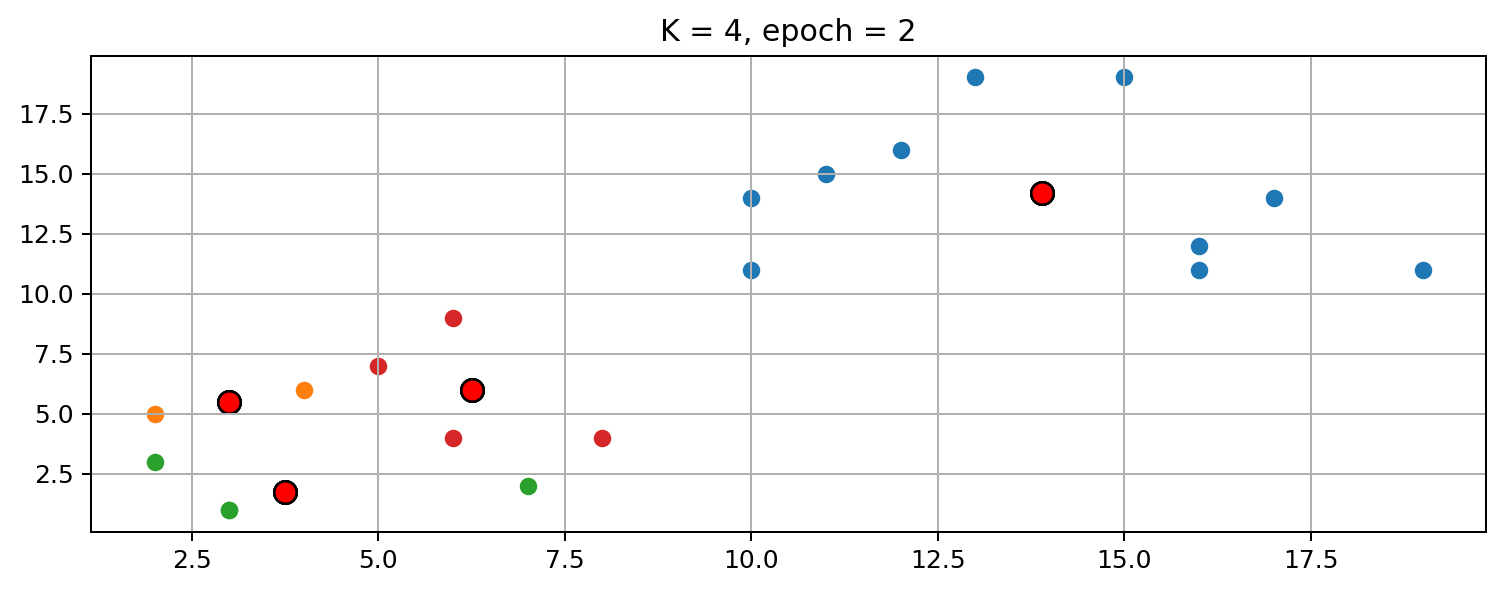

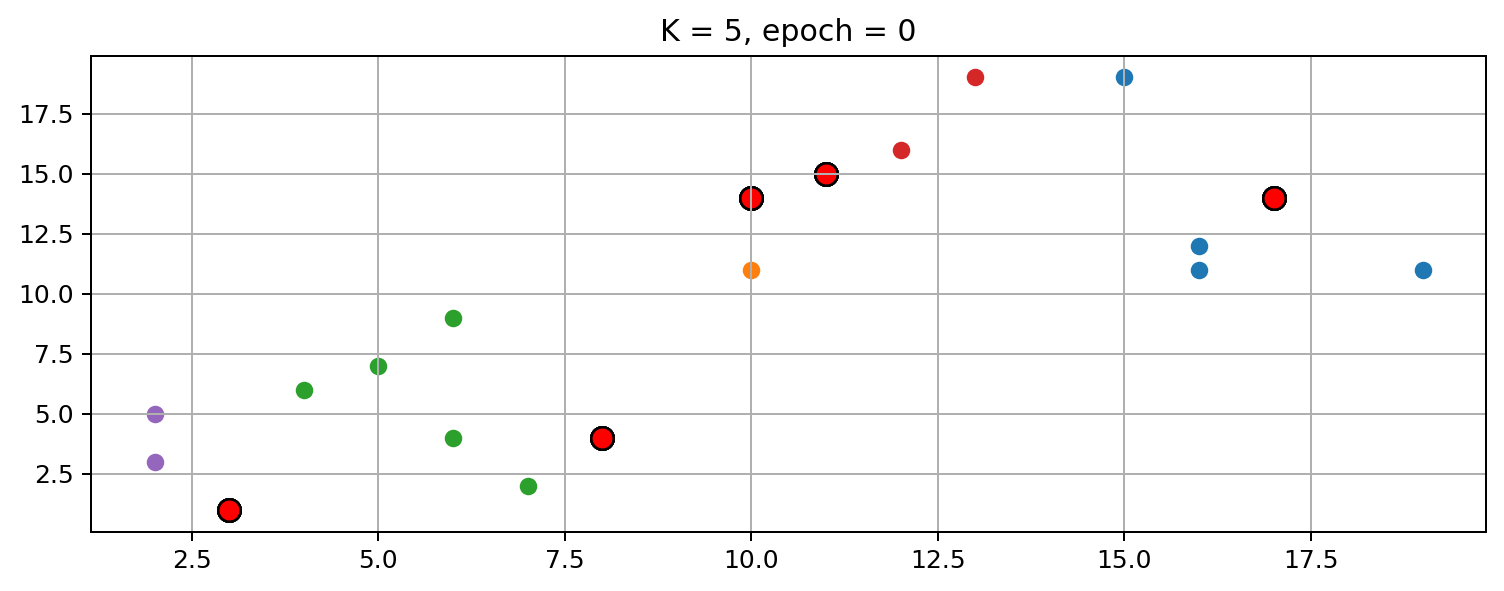

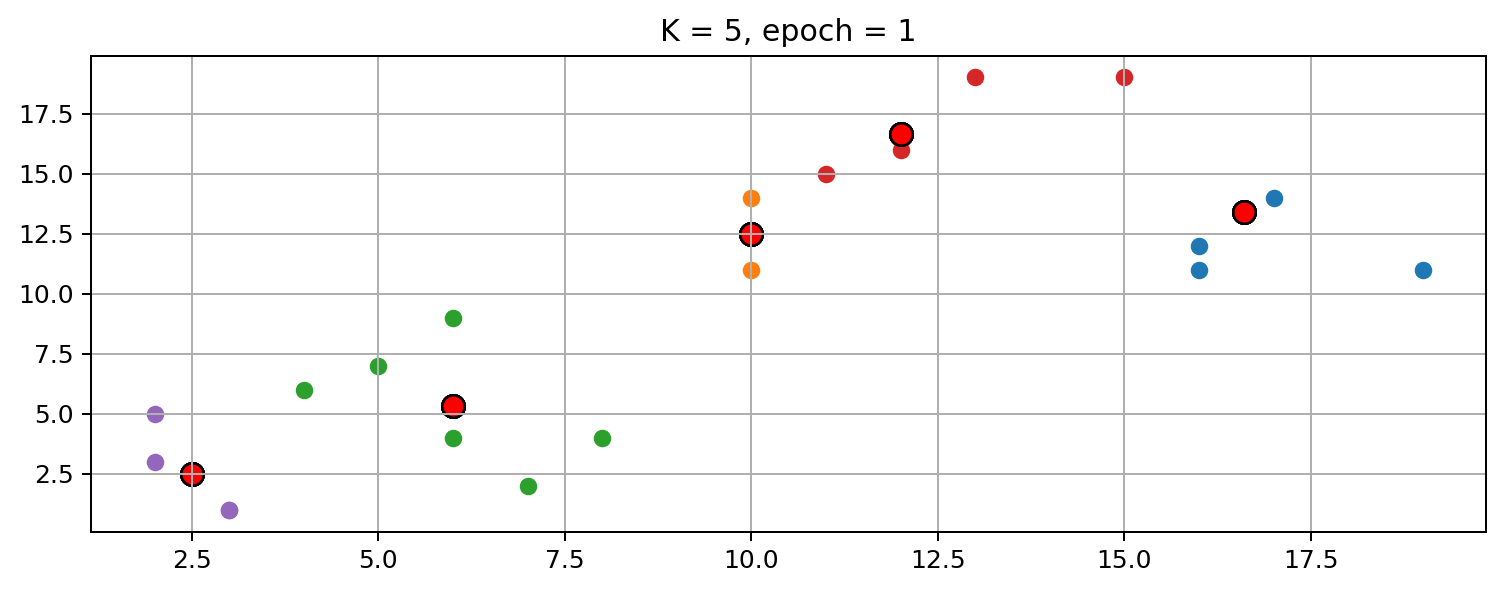

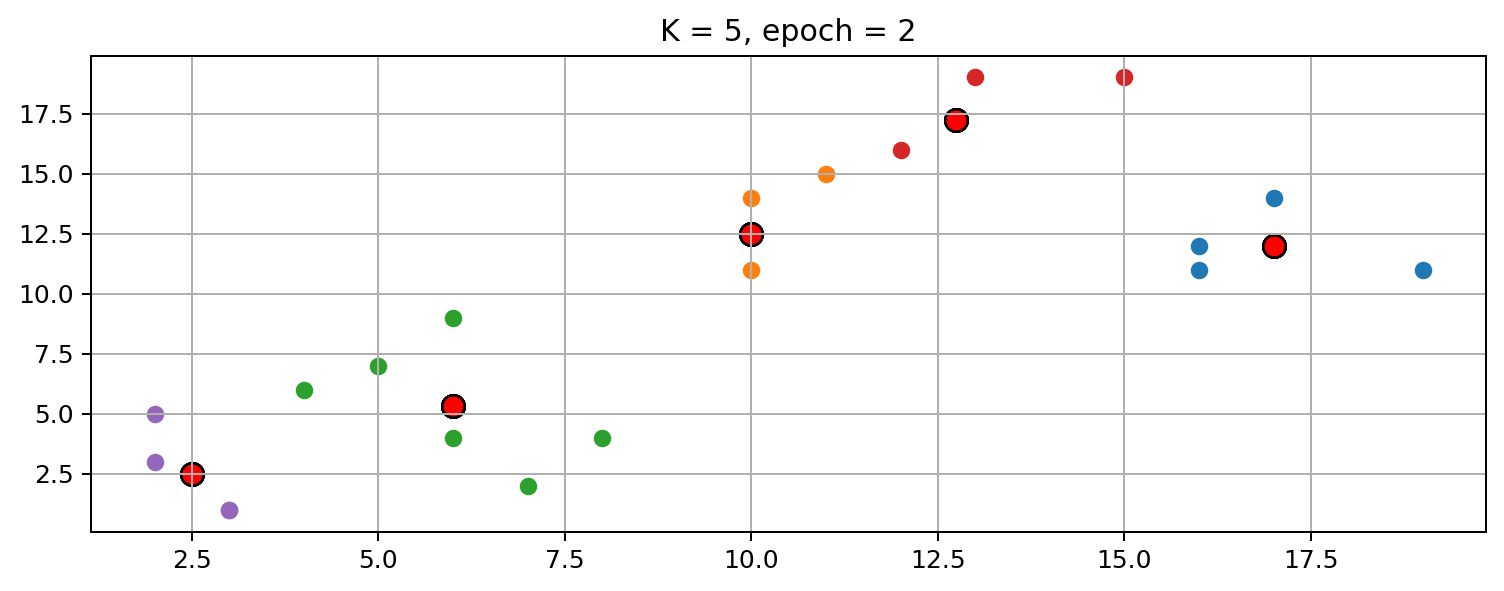

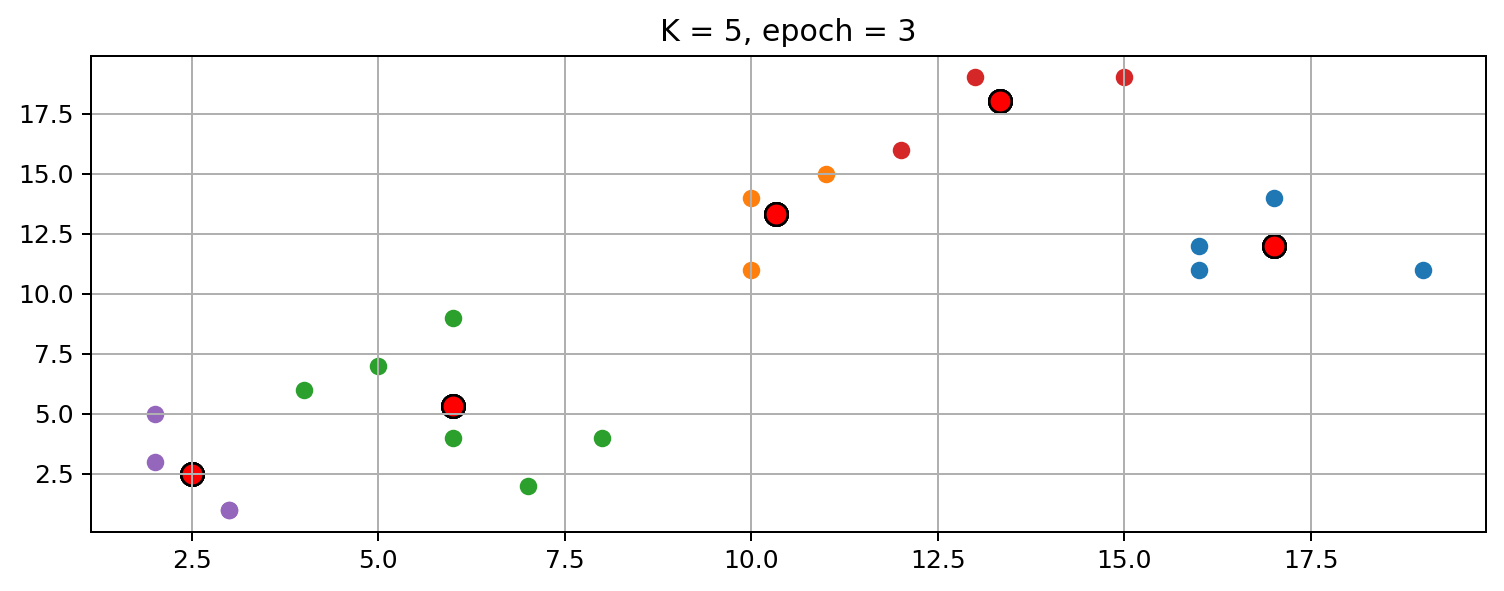

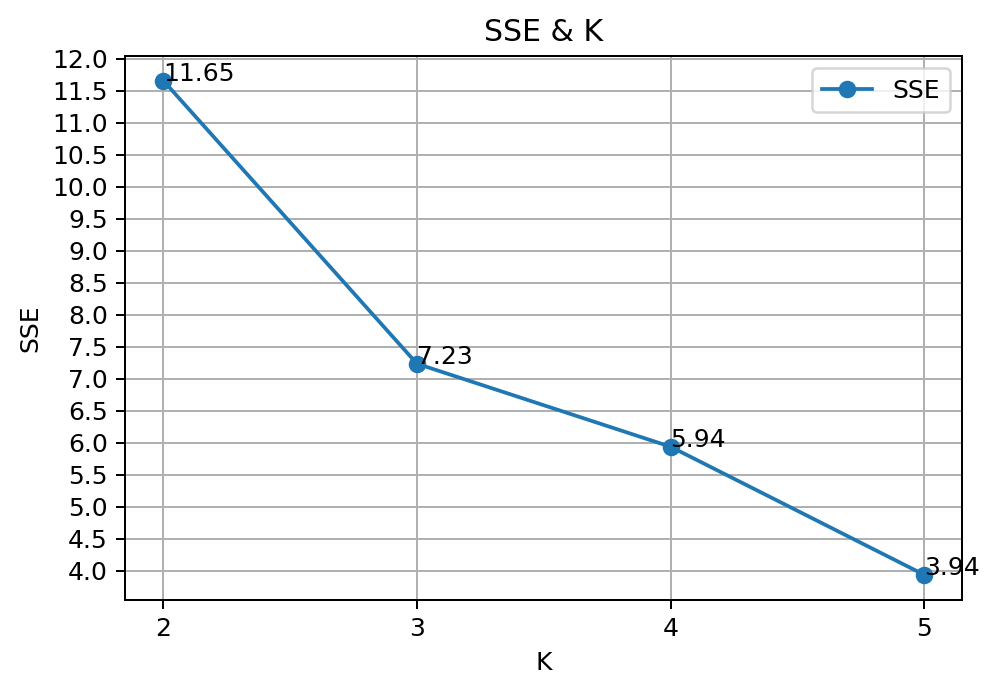

In [79]:
def kmeans_multiple(kmin, kmax):
    global centroids
    sses = []
    ks = []
    for i in range(kmin, kmax + 1):
        centroids = init_centroids(i)
        ks.append(i)
        centroids = init_centroids(i)
        sse = kmeans(i)
        sses.append(sse)

    # Plot result
    plt.plot(ks, sses, "-o")
    plt.grid(True)
    plt.legend({"SSE"})
    ax = plt.gca()
    ax.xaxis.set_major_locator(plt.MultipleLocator(1))
    ax.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    plt.xlabel("K")
    plt.ylabel("SSE")
    plt.title("SSE & K")
    for i,j in zip(ks, sses):
        ax.annotate("{:.2f}".format(j), xy=(i,j))
    plt.savefig("image/output_k_sse.jpg")
    plt.show()

kmeans_multiple(K_MIN, K_MAX)

进一步地，如果采用随机化的数据，可以得到如下结果：

<2021-01-02 20:10:15 INFO>: K-Means started. K = 2, MAX_EPOCHS = 20
<2021-01-02 20:10:15 INFO>: [EPOCH 0] Centroid updated: [[1.39 2.06] [0.91 0.61]]
<2021-01-02 20:10:15 INFO>: [EPOCH 0] Current SSE: 9.822143604596638; Centroid offset: 0.7292699879318729
<2021-01-02 20:10:16 INFO>: [EPOCH 1] Centroid updated: [[1.54 1.94] [0.78 0.55]]
<2021-01-02 20:10:16 INFO>: [EPOCH 1] Current SSE: 9.27796327771051; Centroid offset: 0.23616684890960687
<2021-01-02 20:10:16 INFO>: [EPOCH 2] Centroid updated: [[1.62 1.87] [0.72 0.56]]
<2021-01-02 20:10:16 INFO>: [EPOCH 2] Current SSE: 9.097773821497823; Centroid offset: 0.12885846475449902
<2021-01-02 20:10:17 INFO>: [EPOCH 3] Centroid updated: [[1.66 1.82] [0.68 0.56]]
<2021-01-02 20:10:17 INFO>: [EPOCH 3] Current SSE: 9.03937184802346; Centroid offset: 0.06770344843990612
<2021-01-02 20:10:17 INFO>: [EPOCH 4] Centroids are almost stable. Iterating stopped.
<2021-01-02 20:10:17 INFO>: [EPOCH 4] Current SSE: 9.024769146428346; Centroid offset: 0.0185

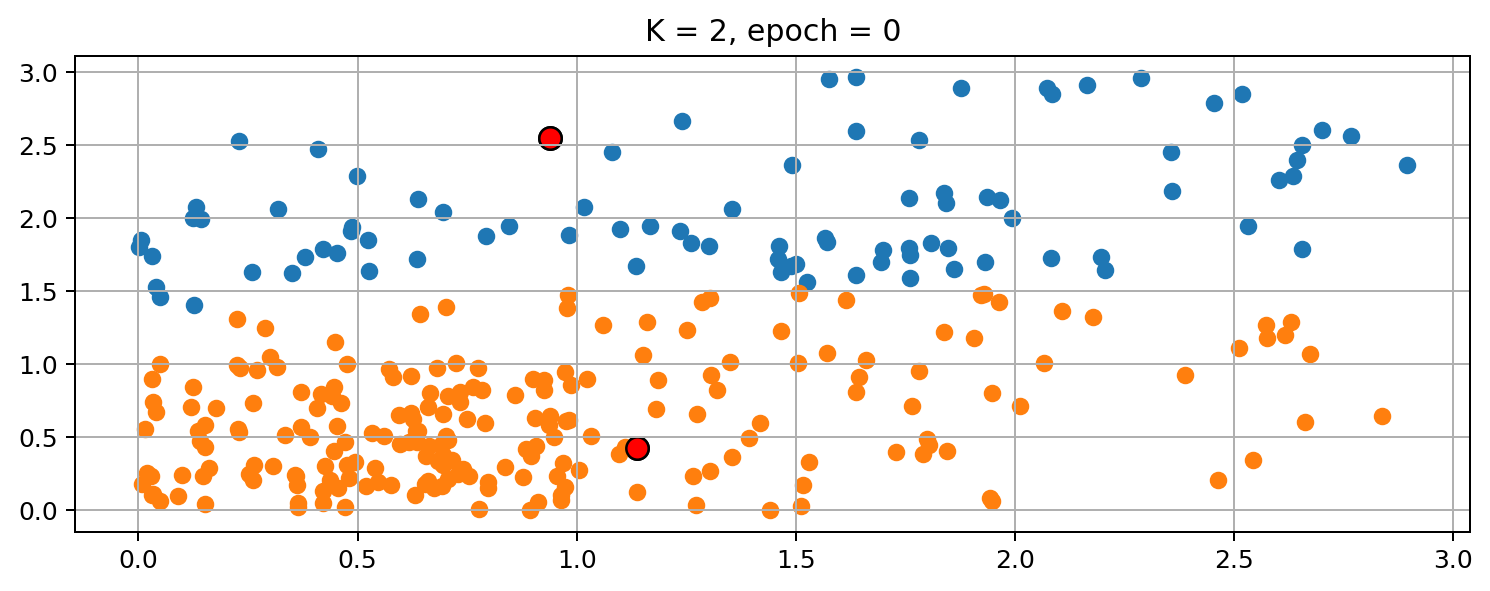

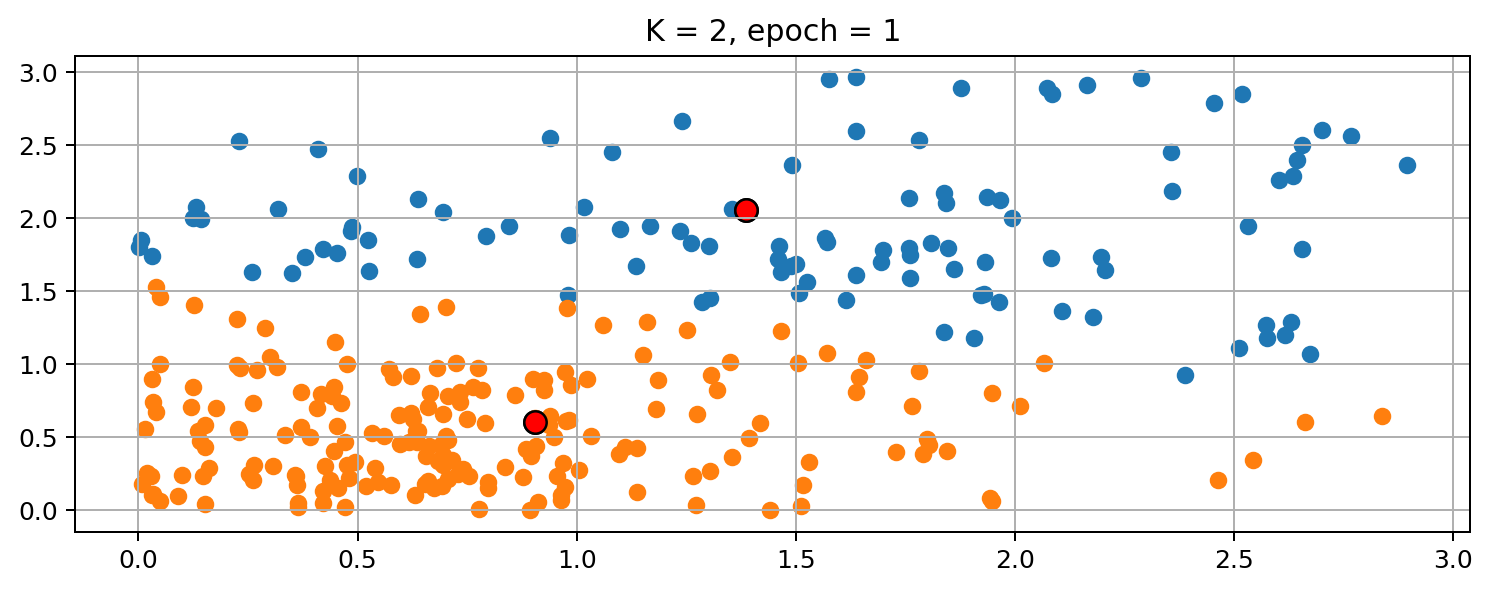

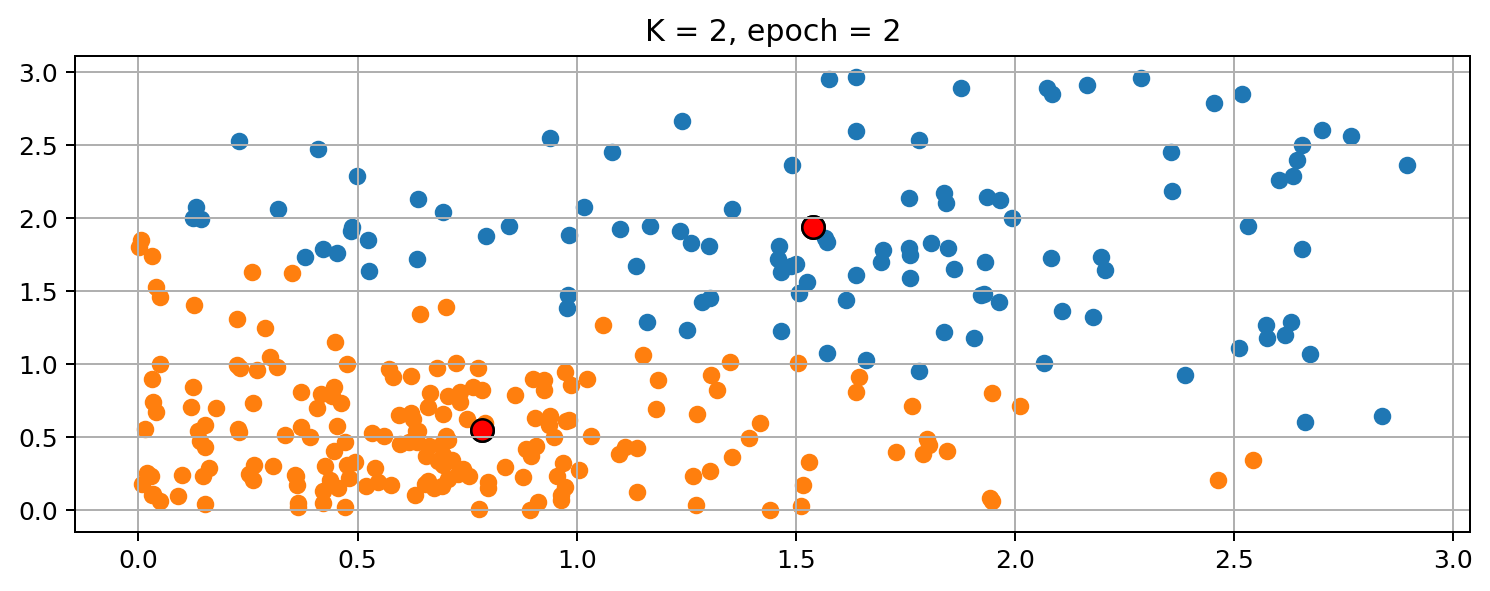

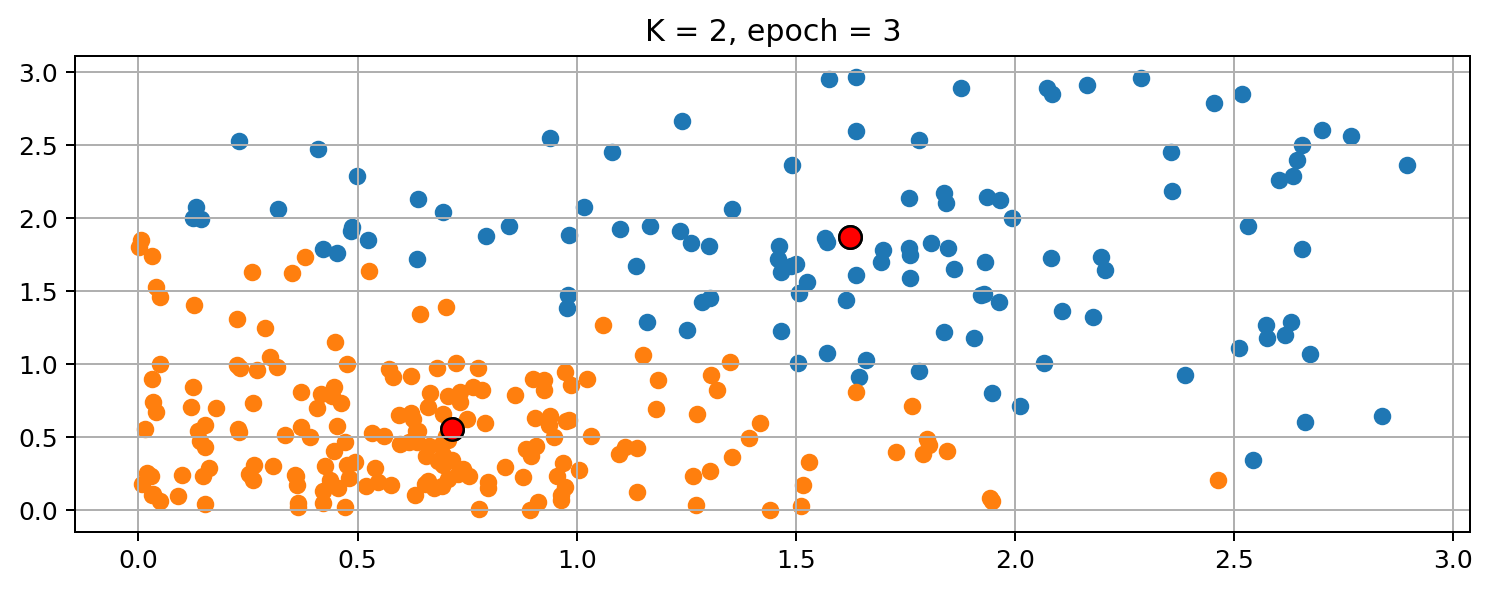

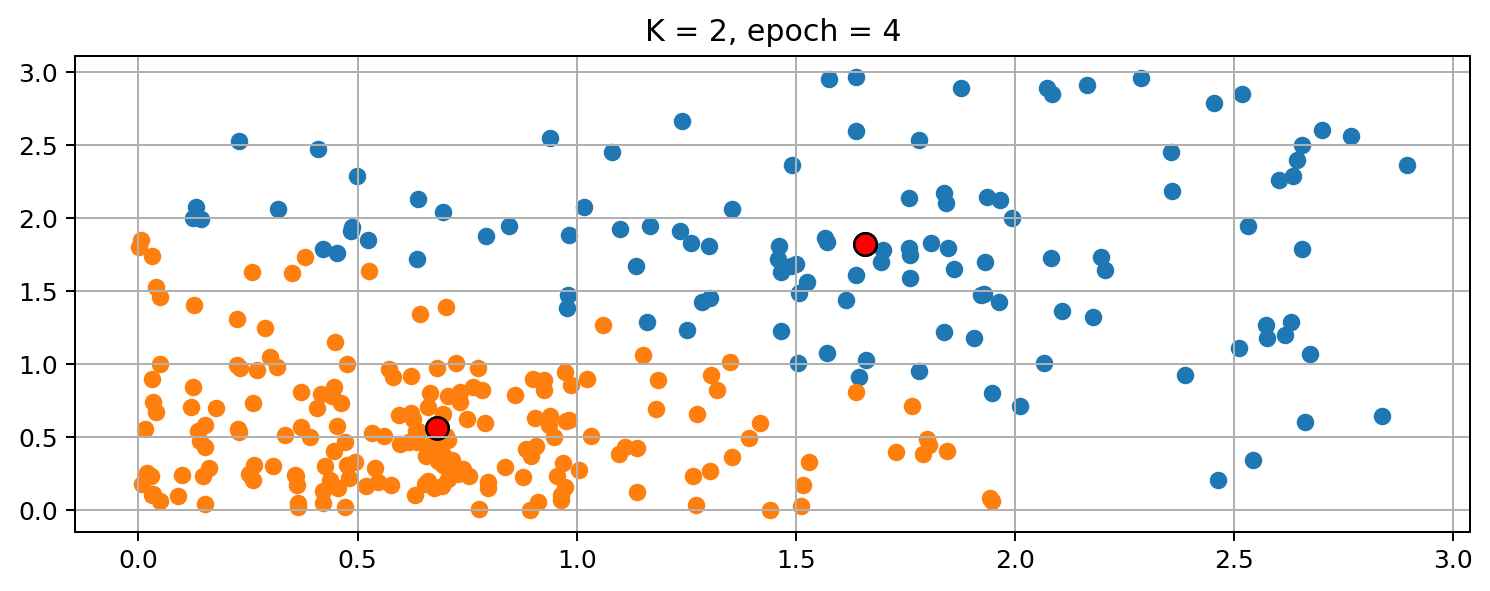

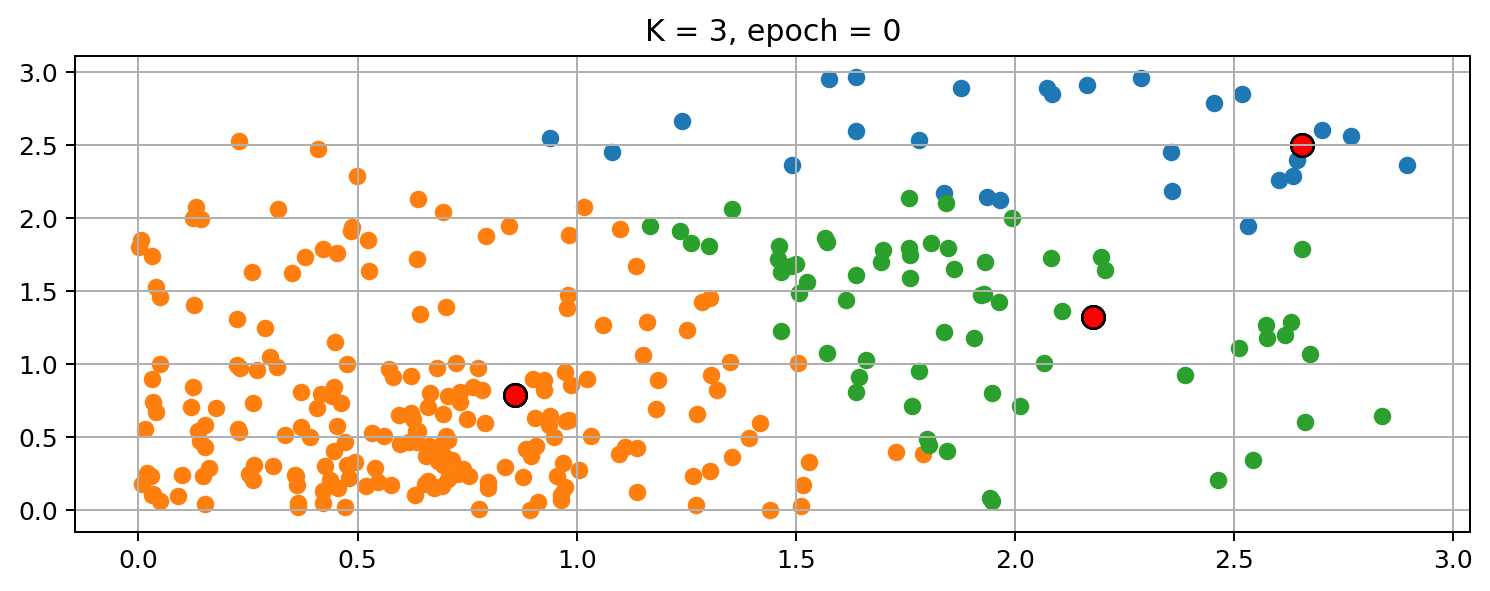

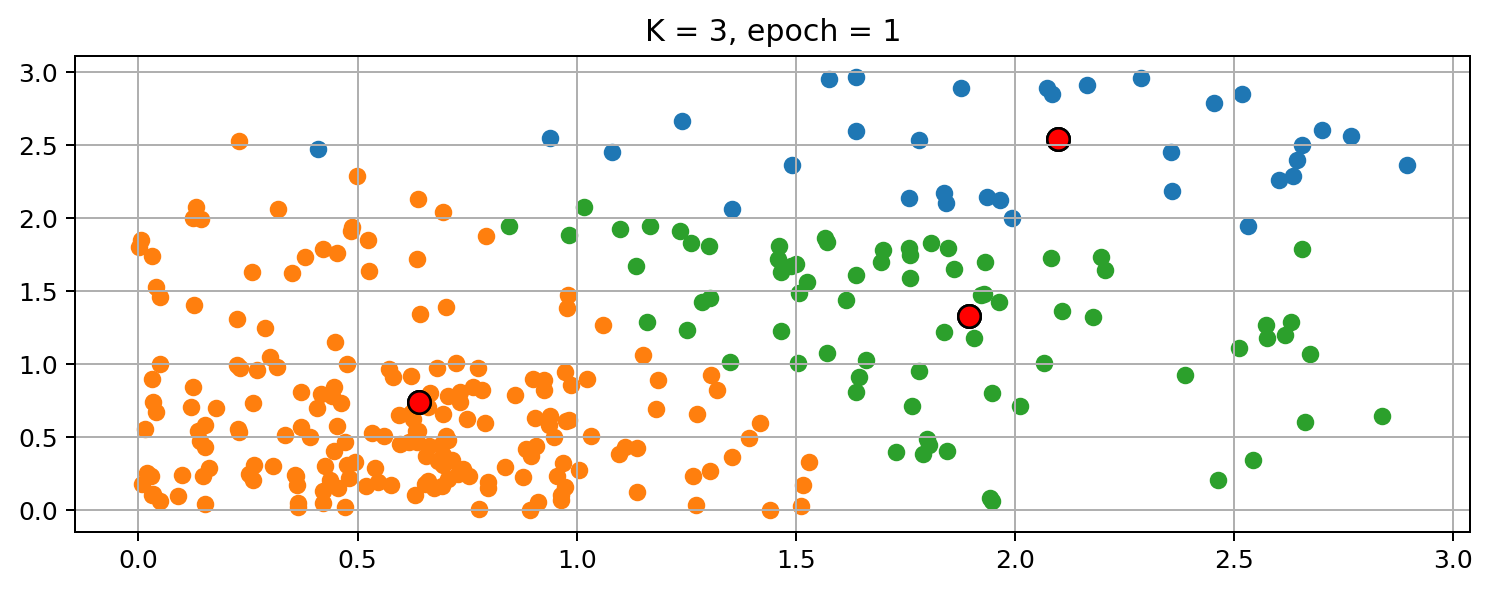

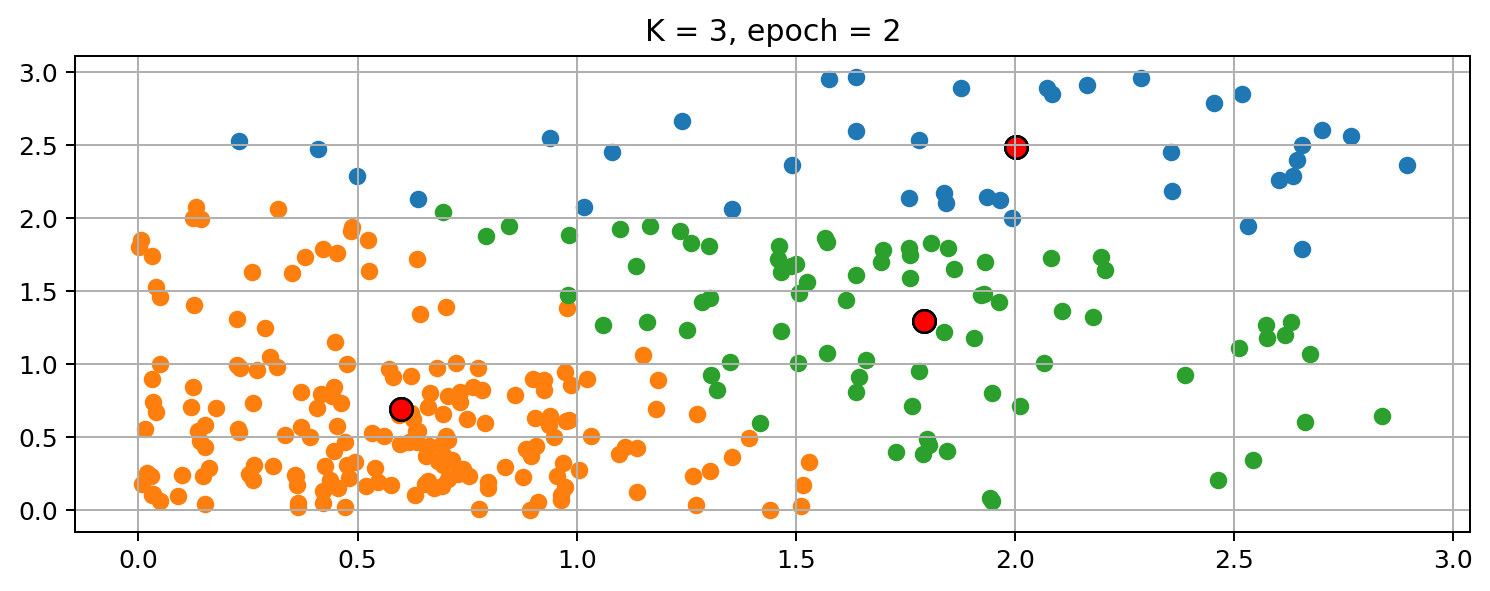

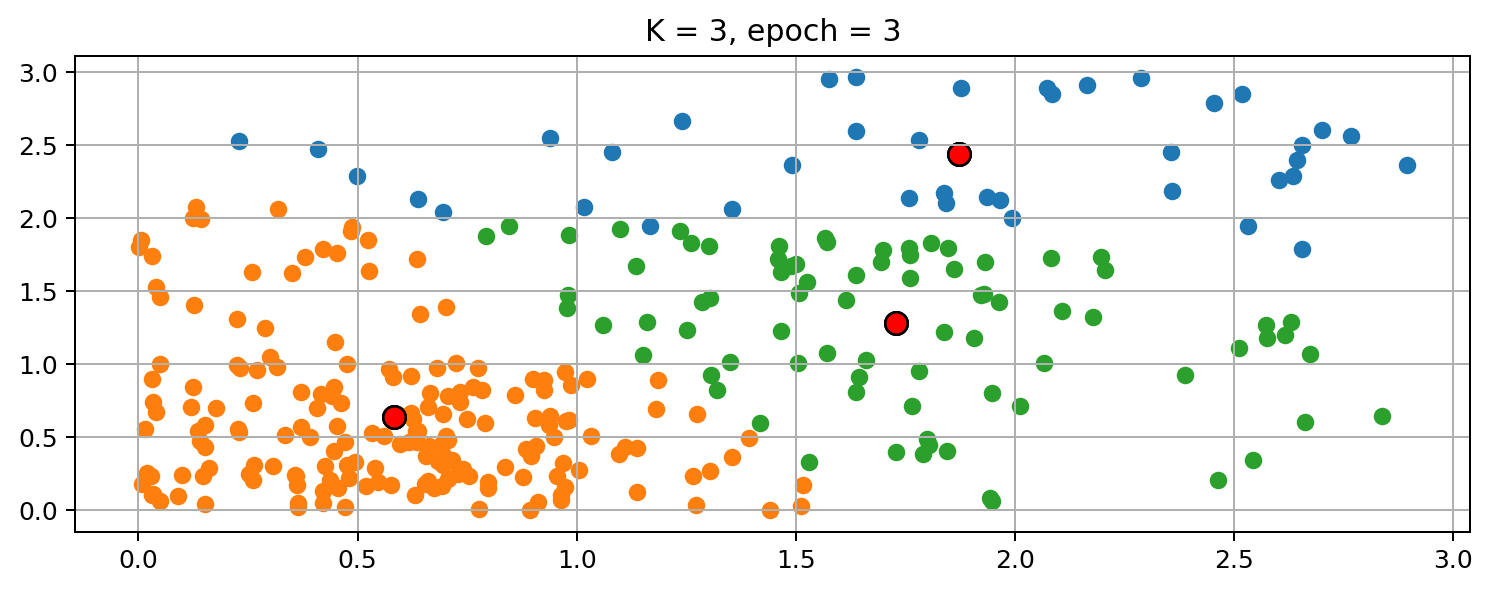

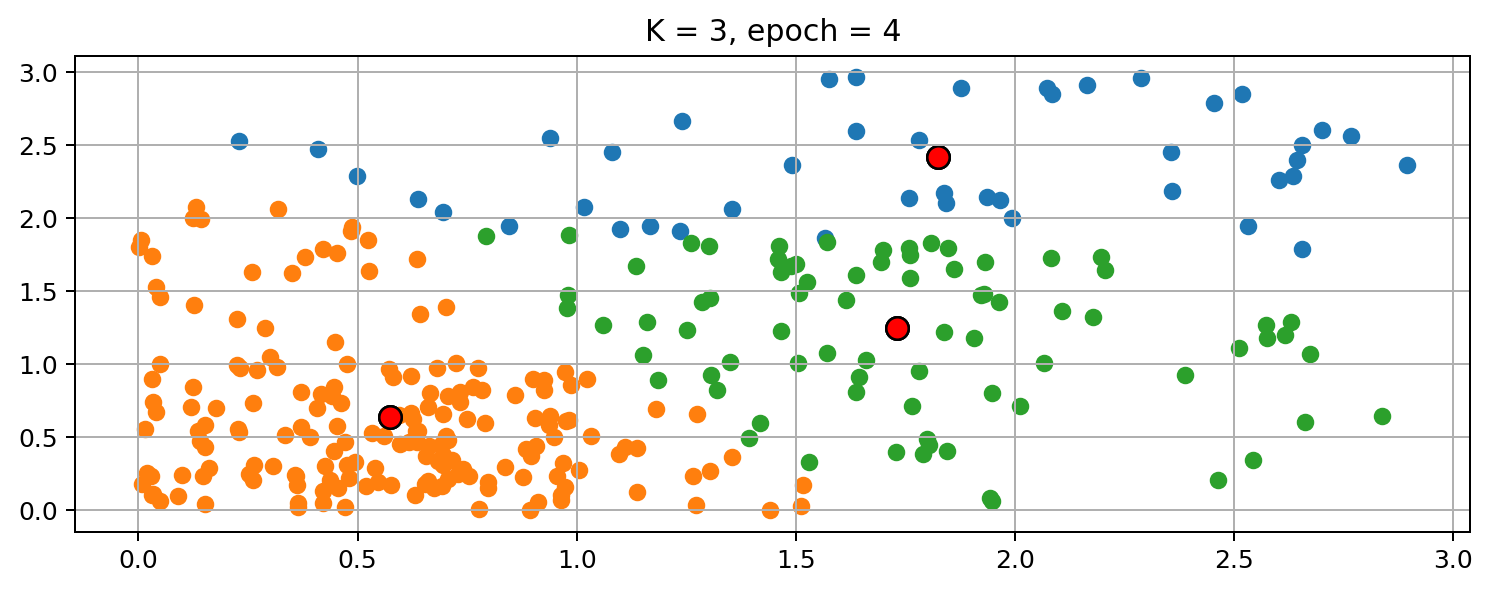

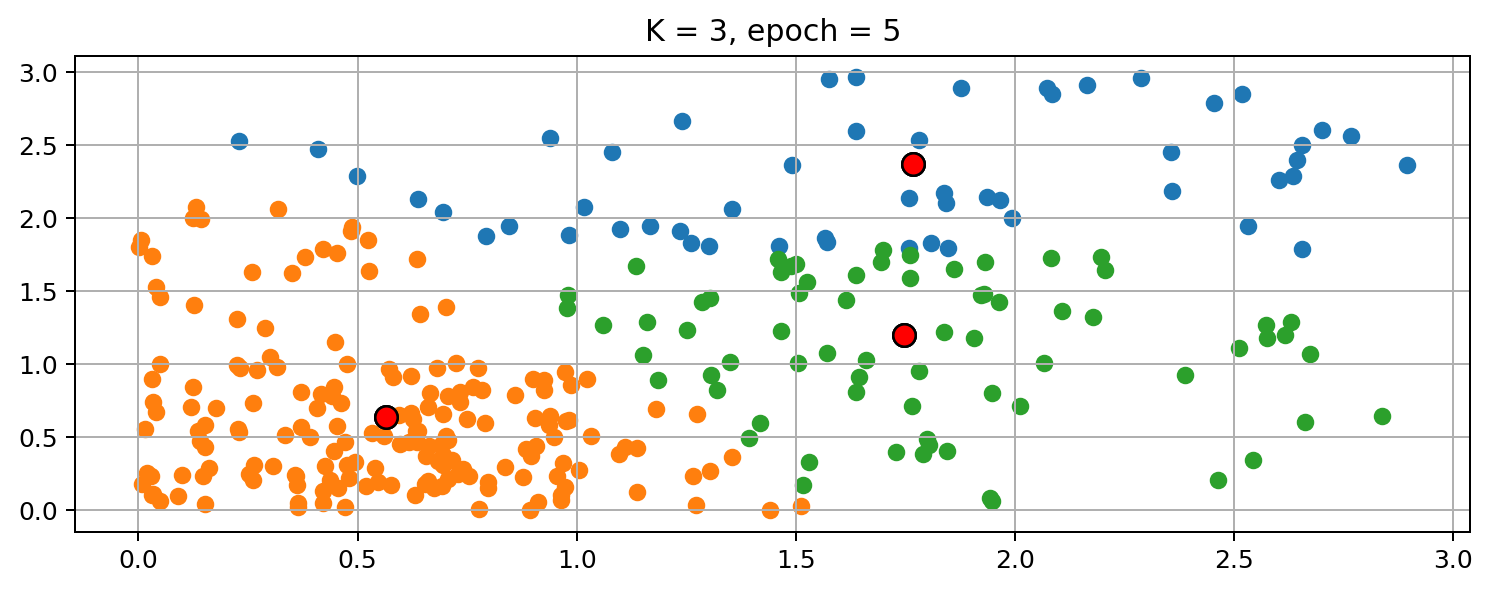

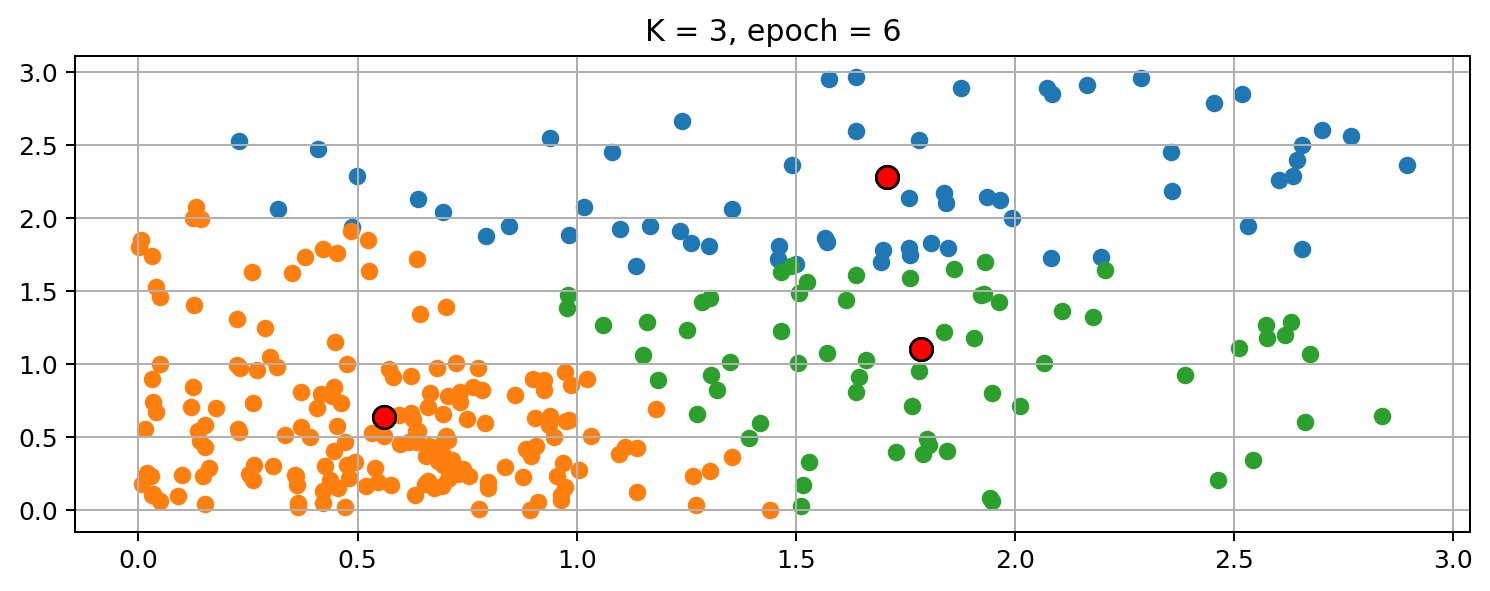

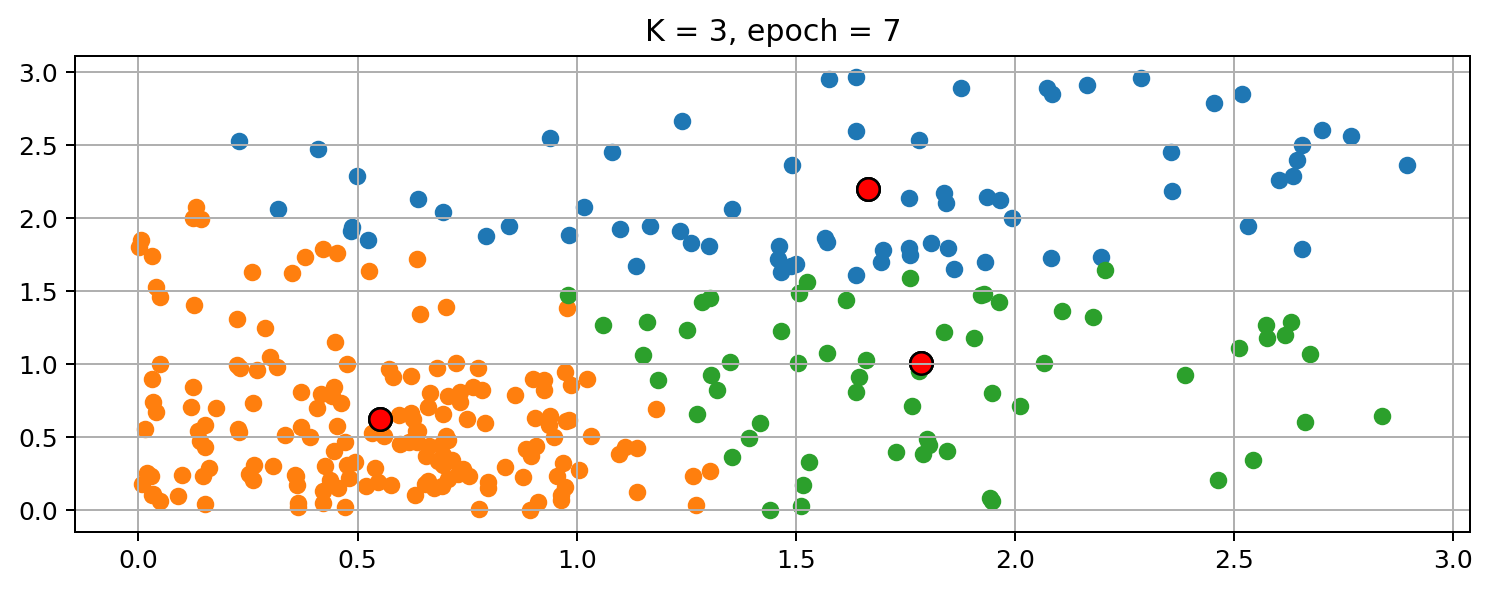

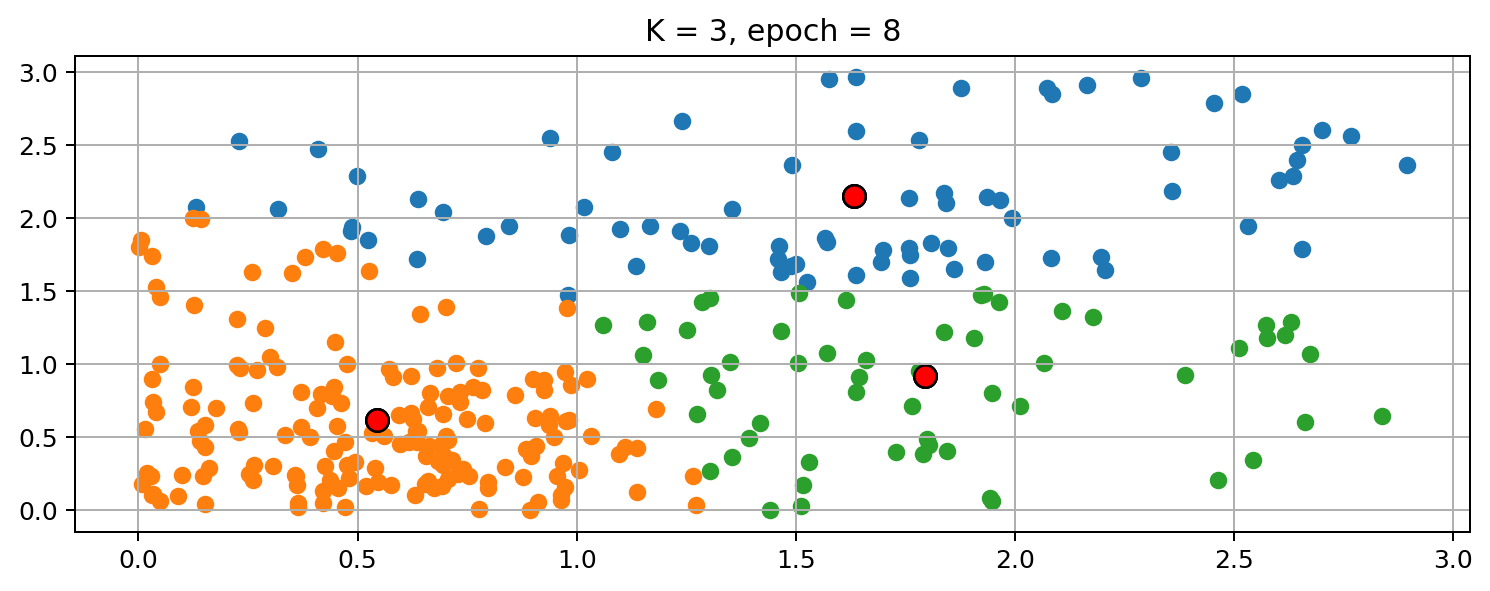

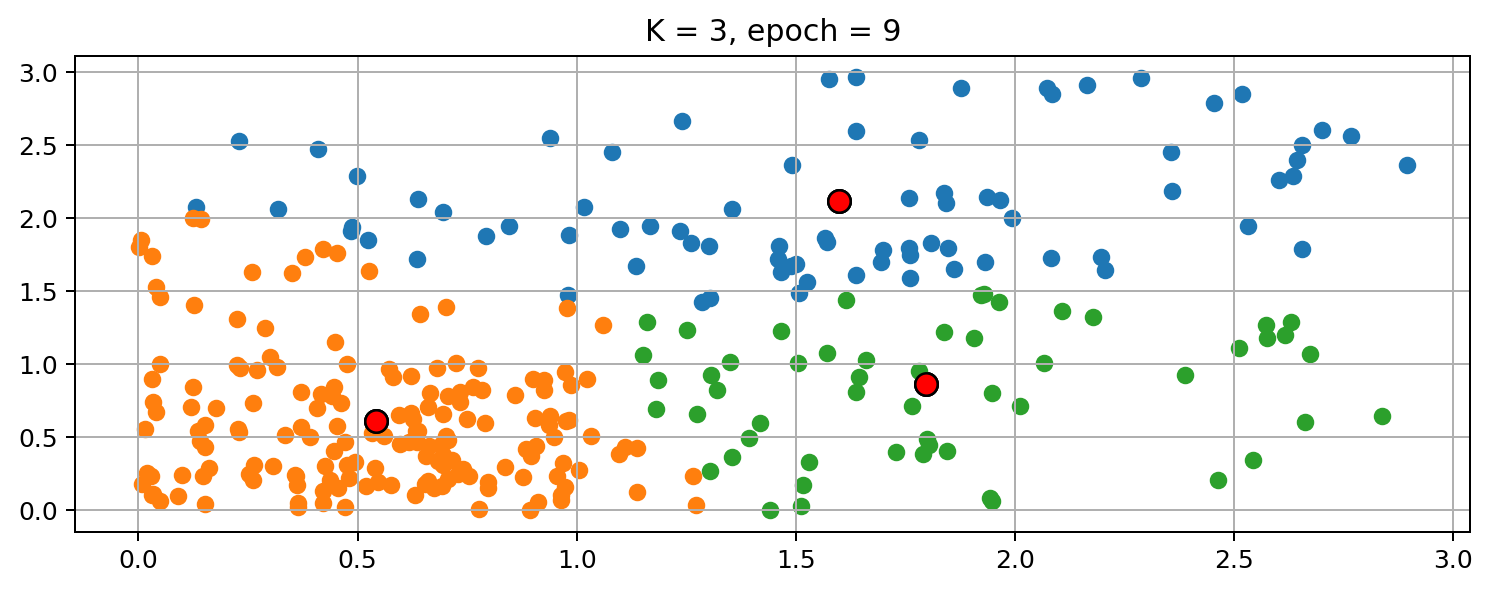

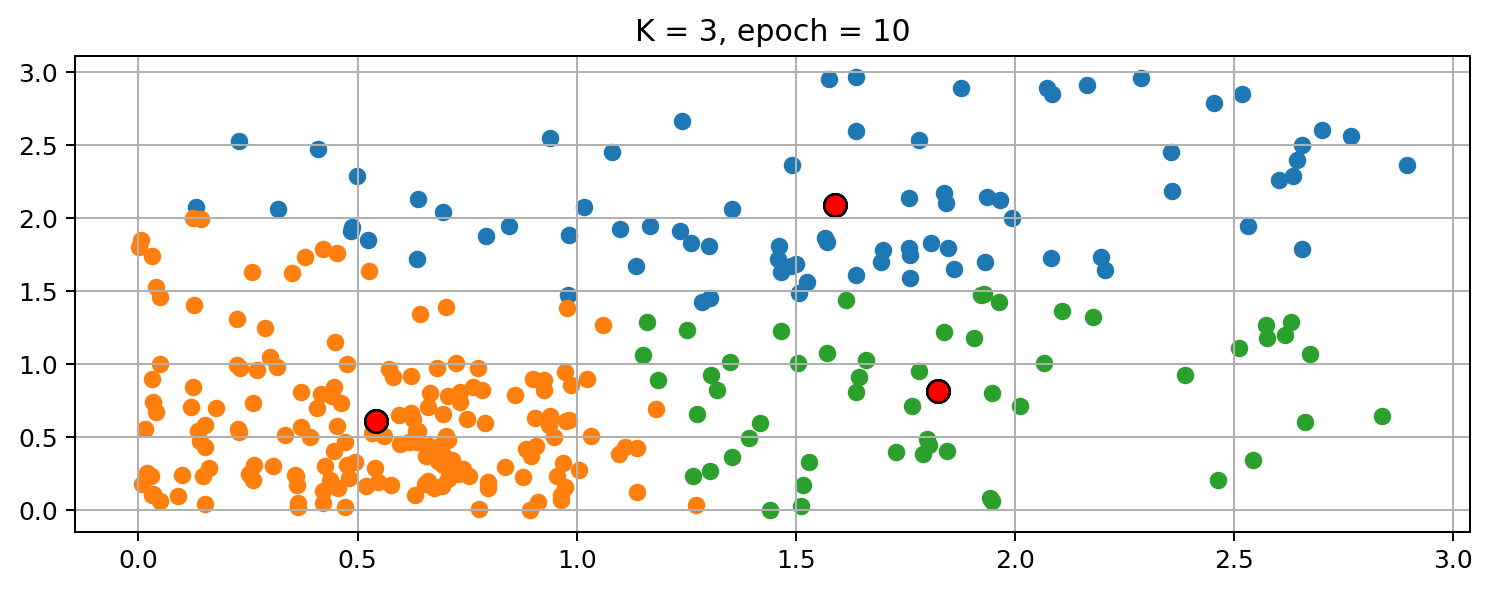

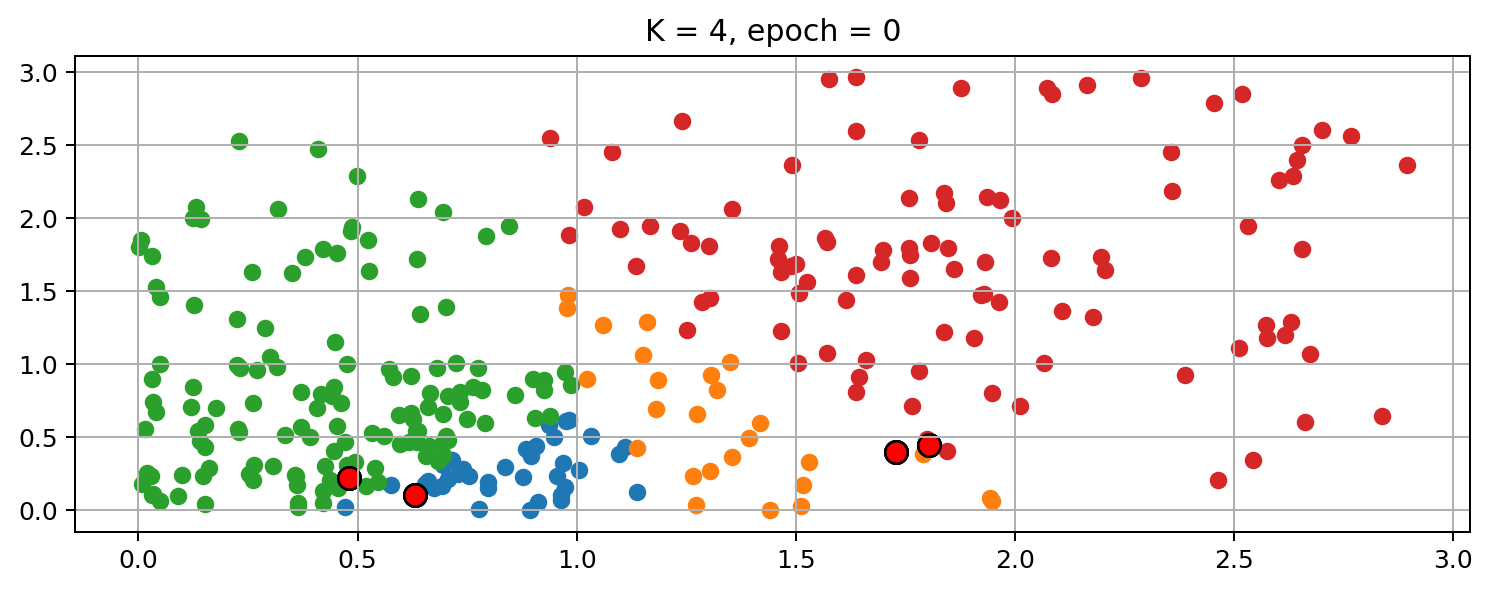

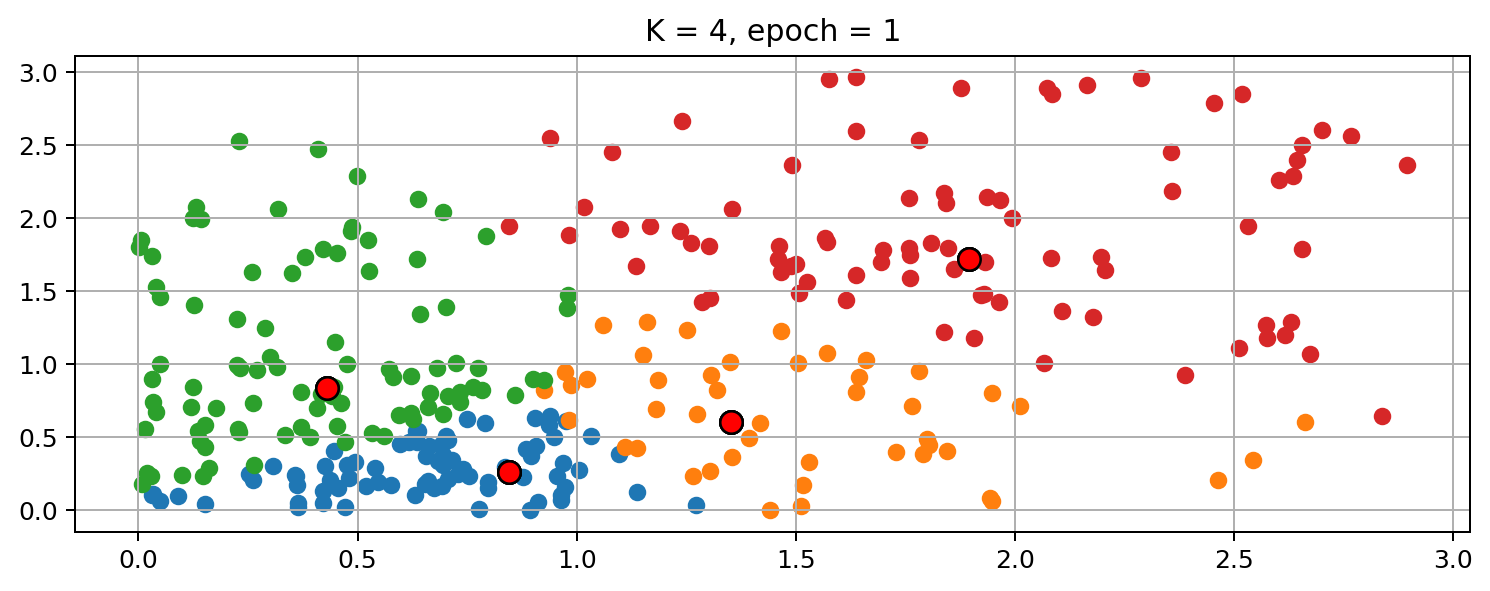

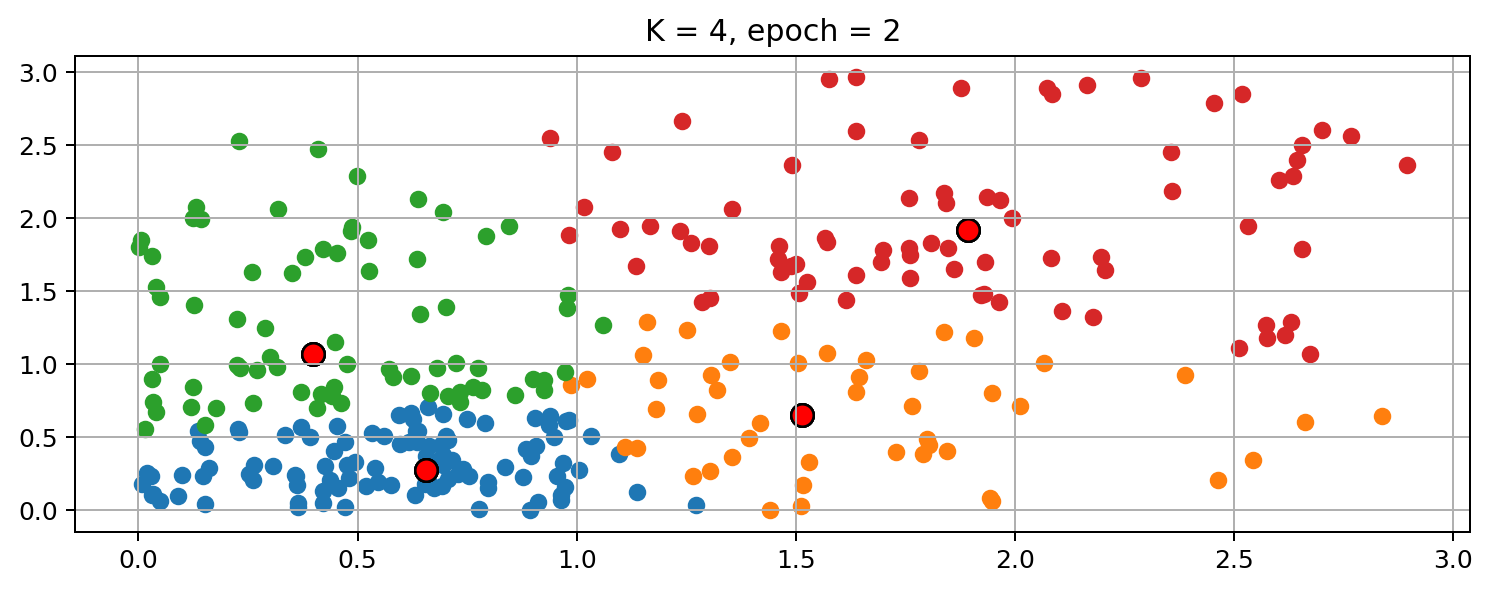

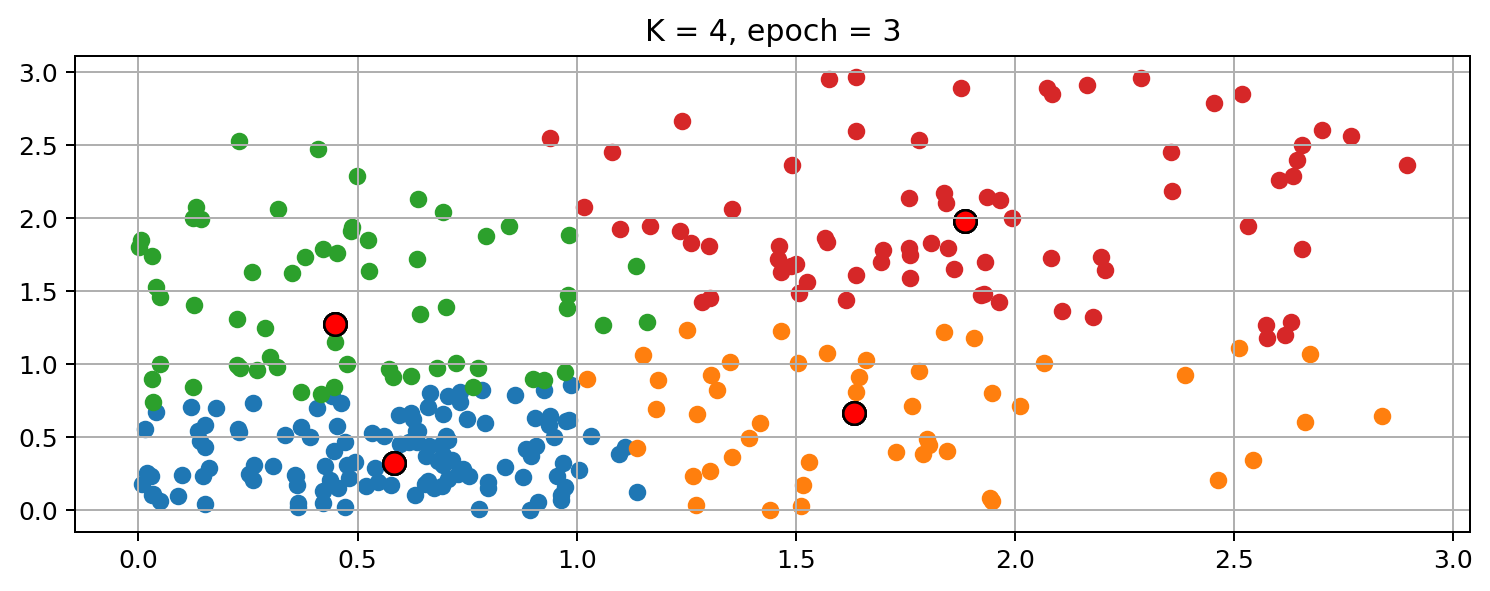

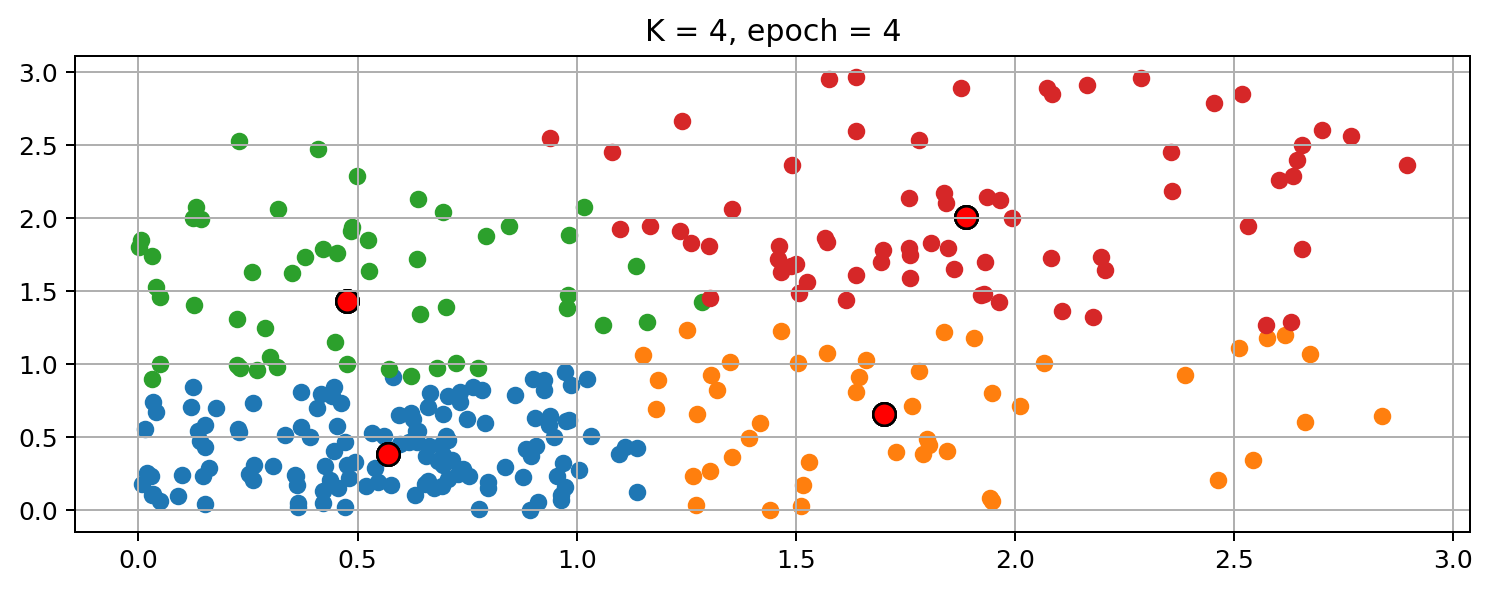

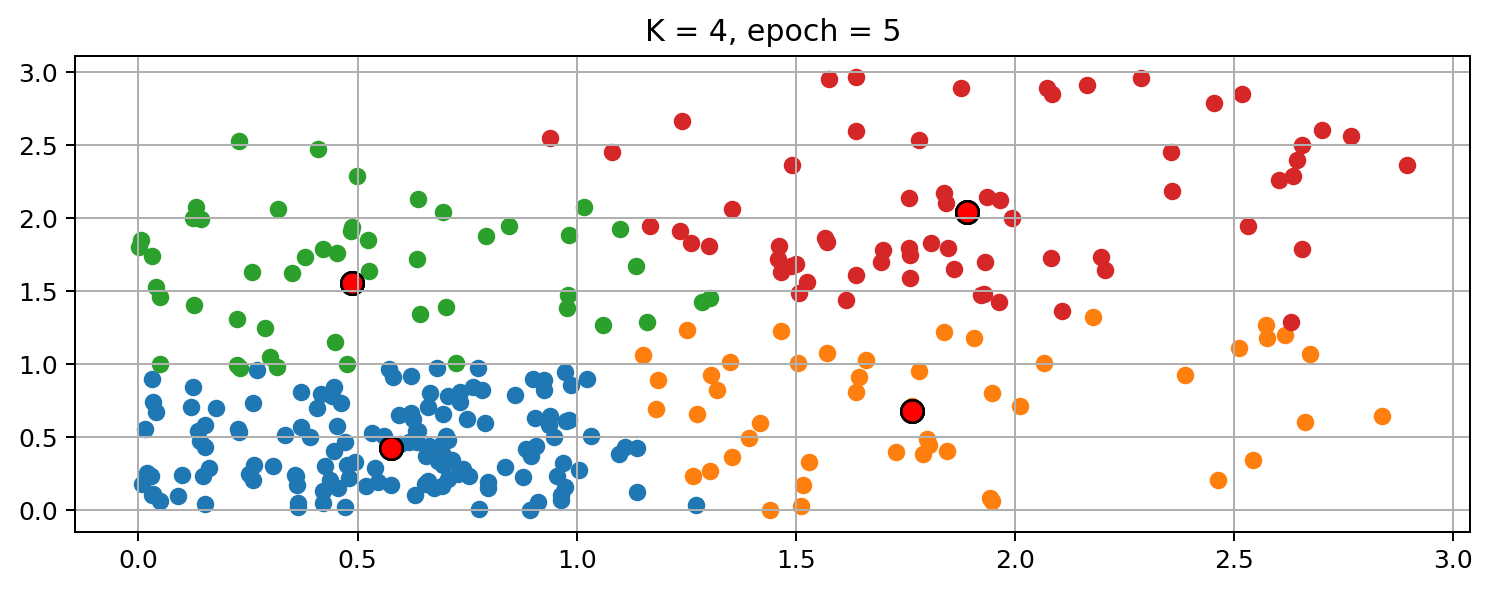

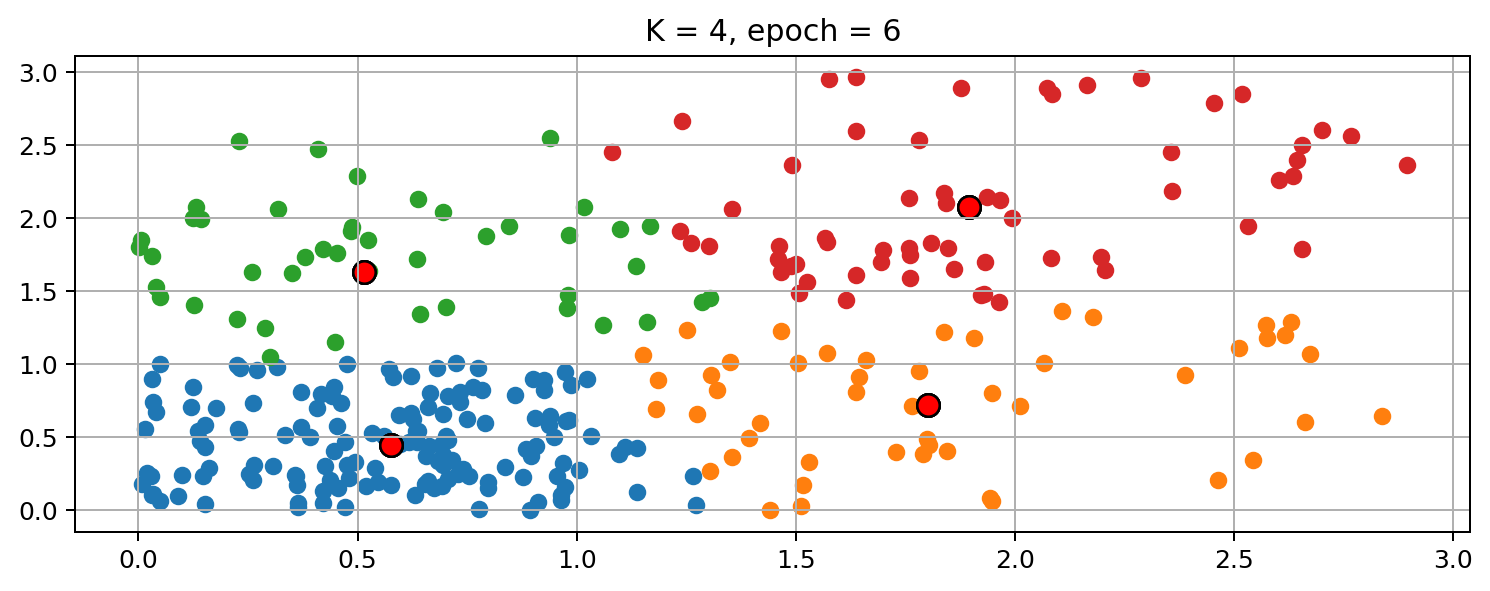

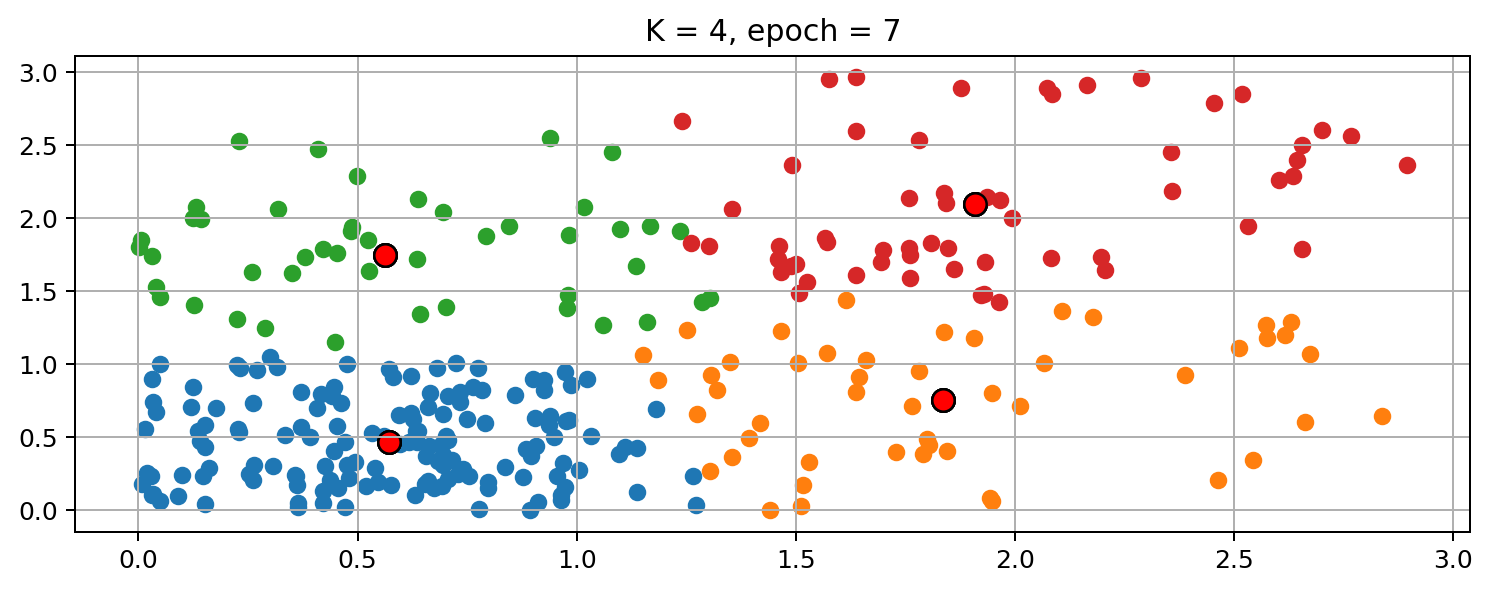

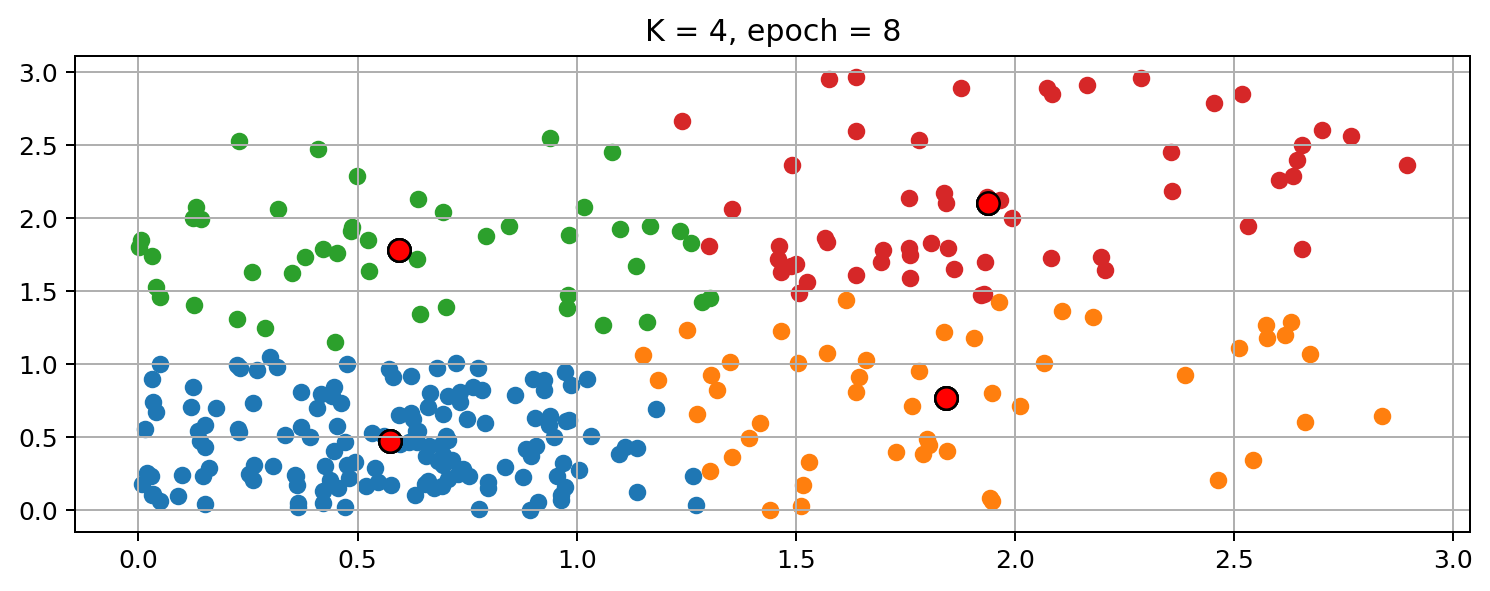

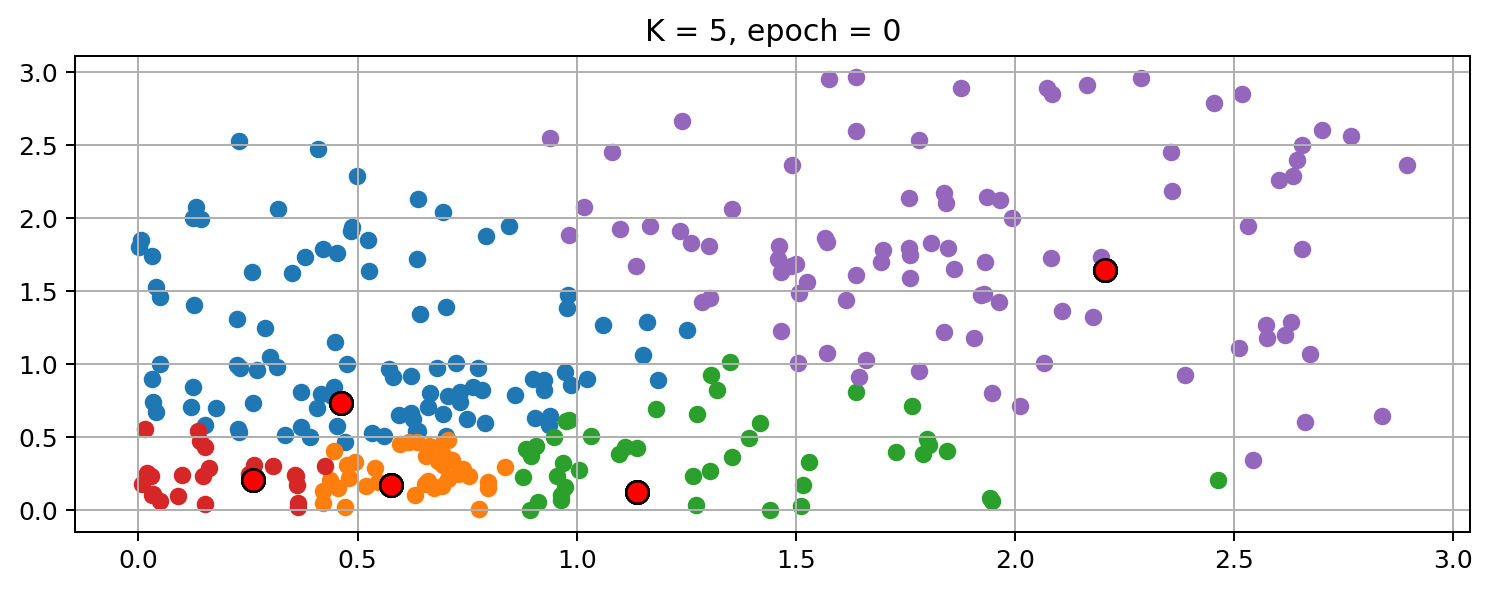

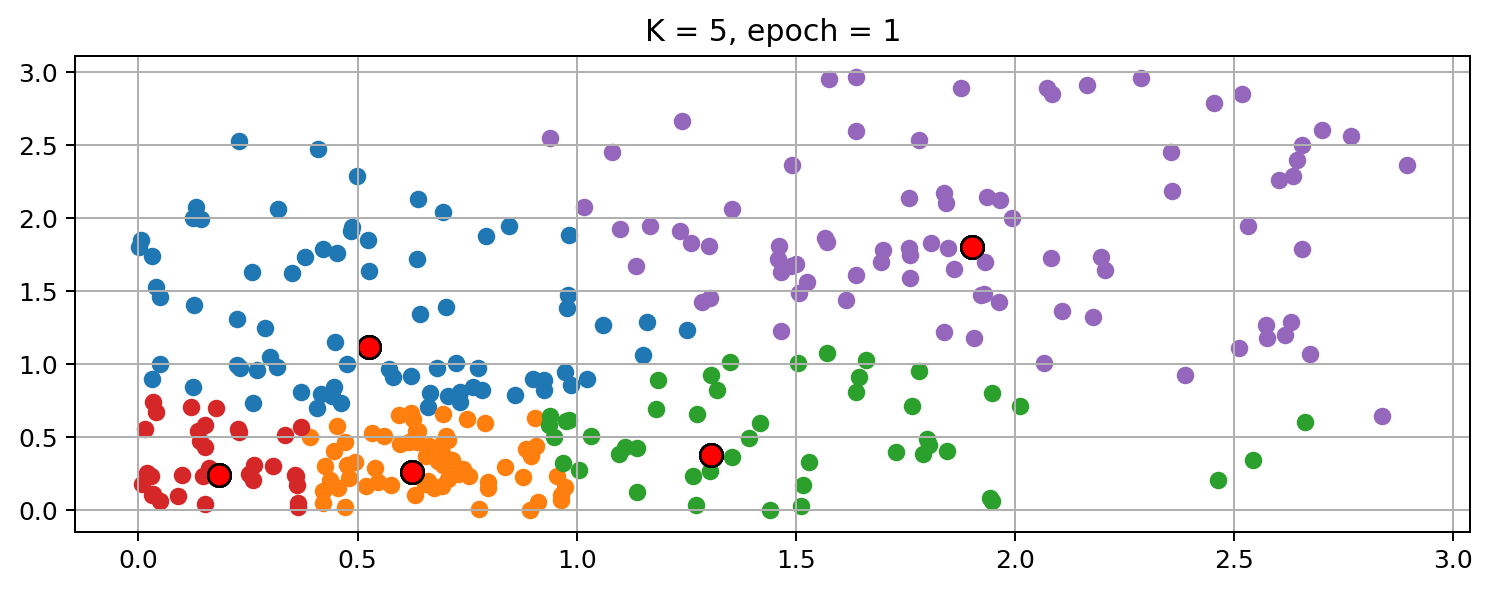

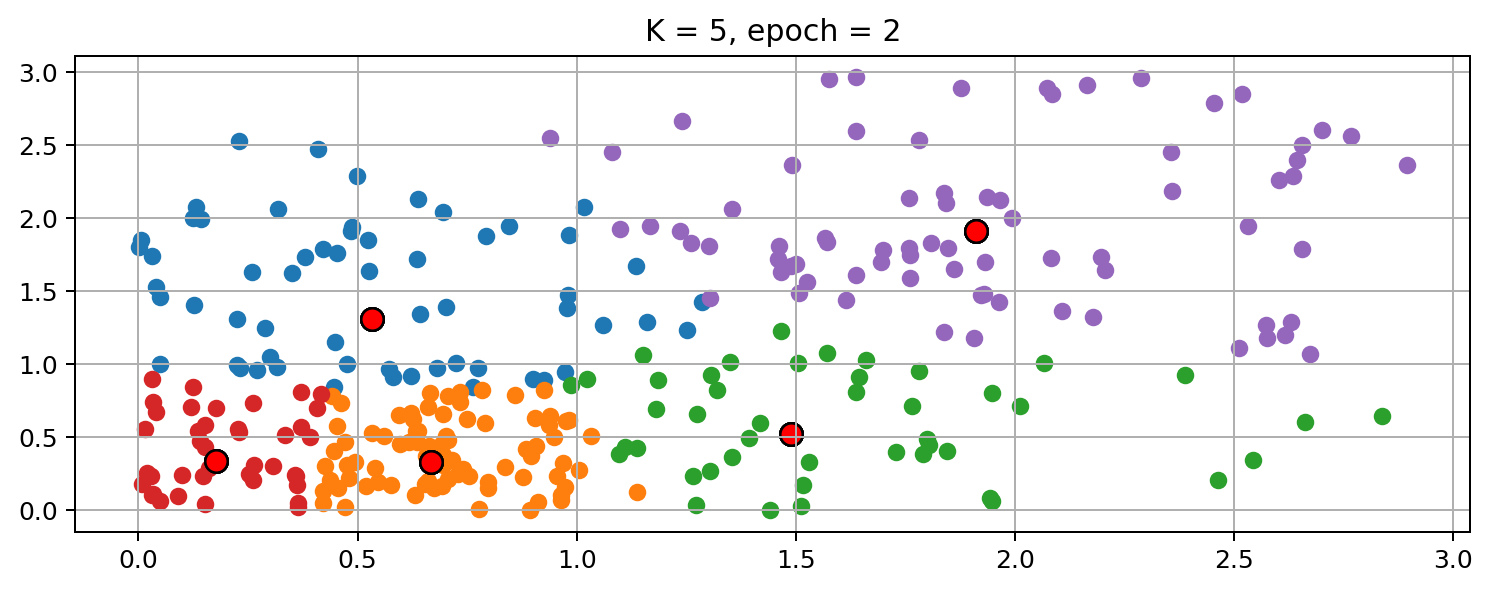

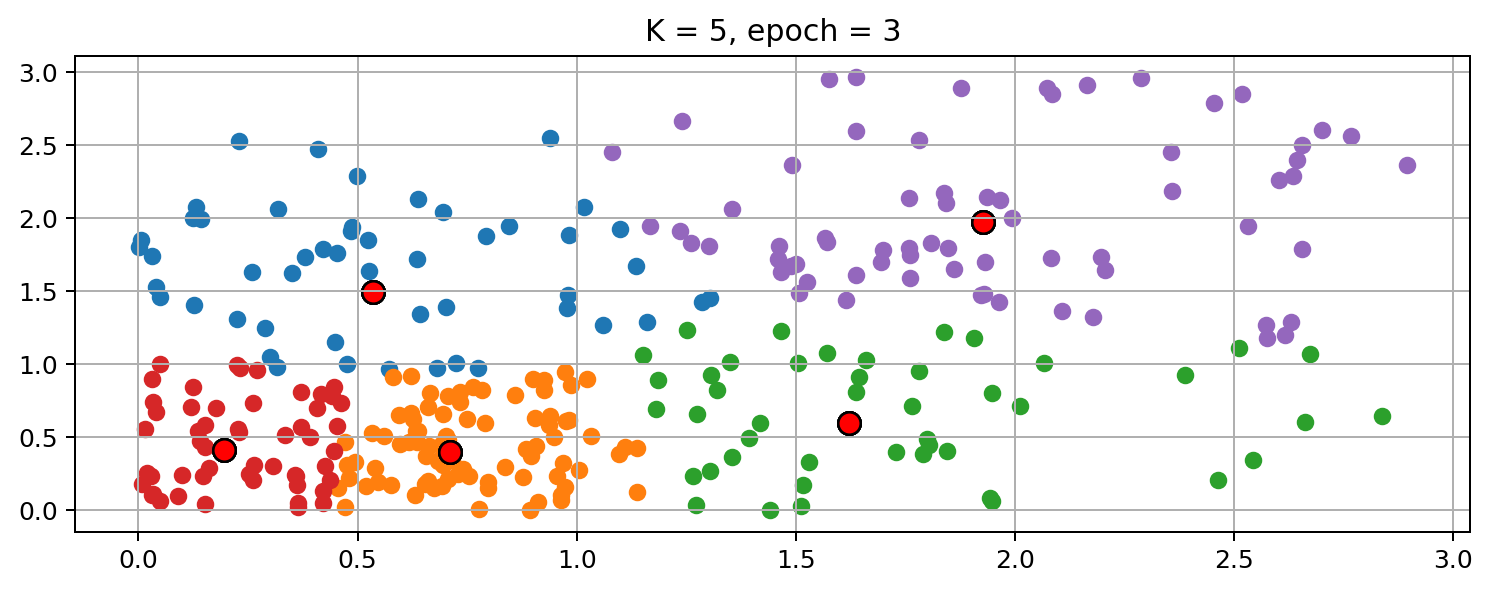

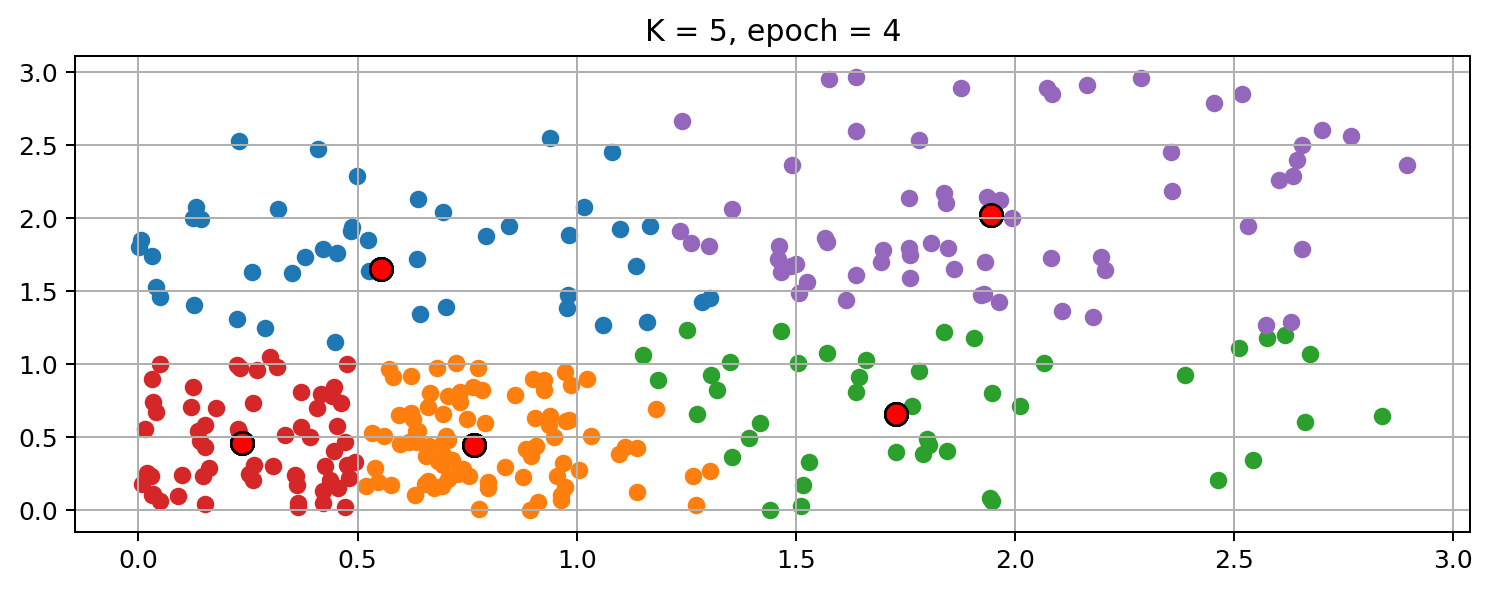

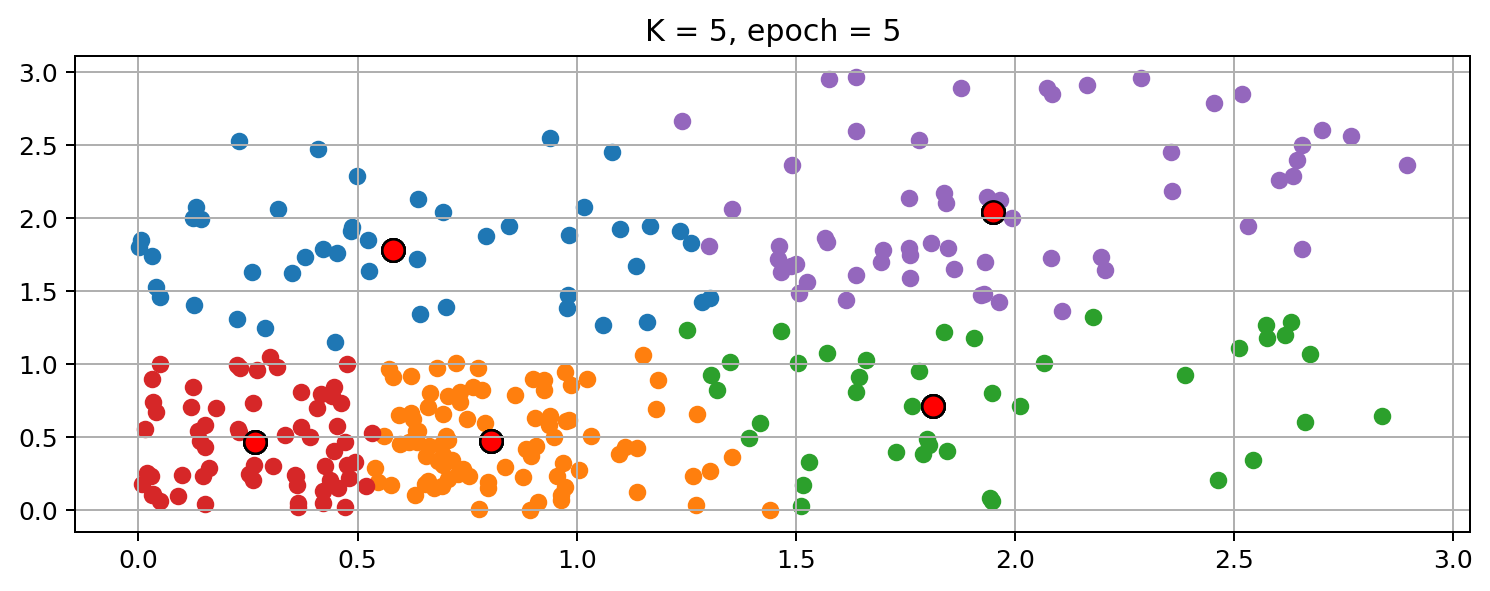

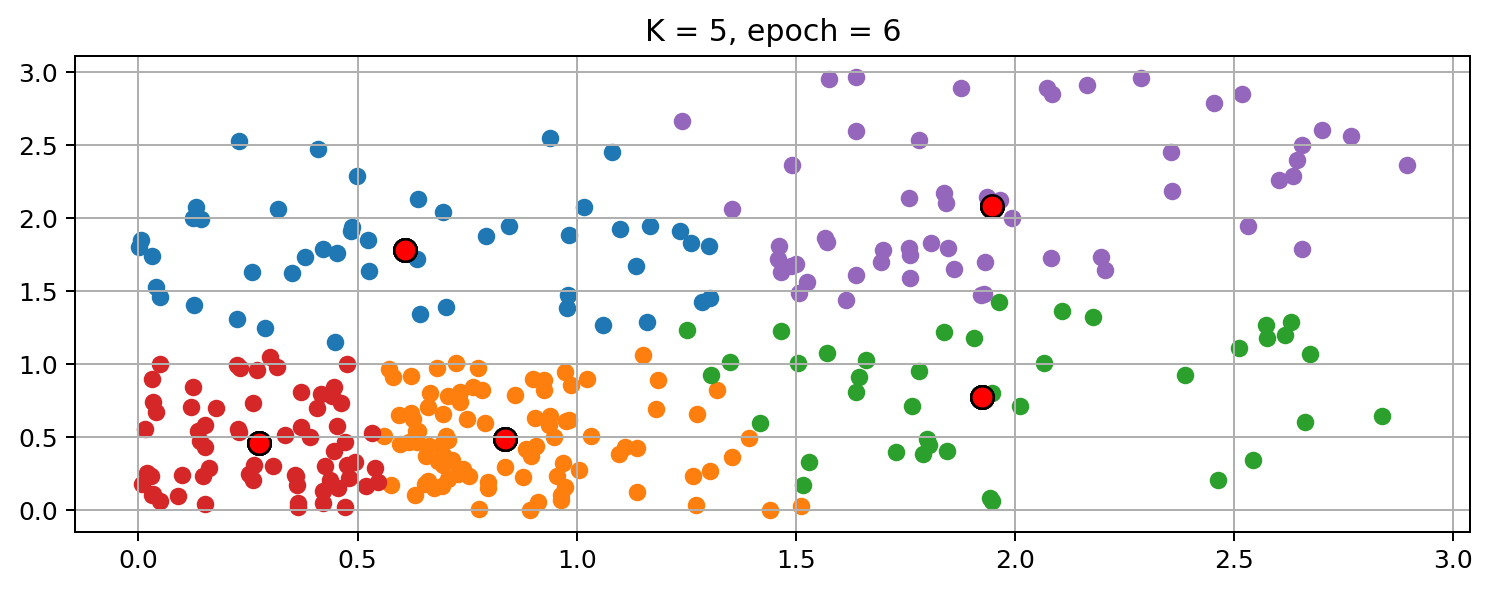

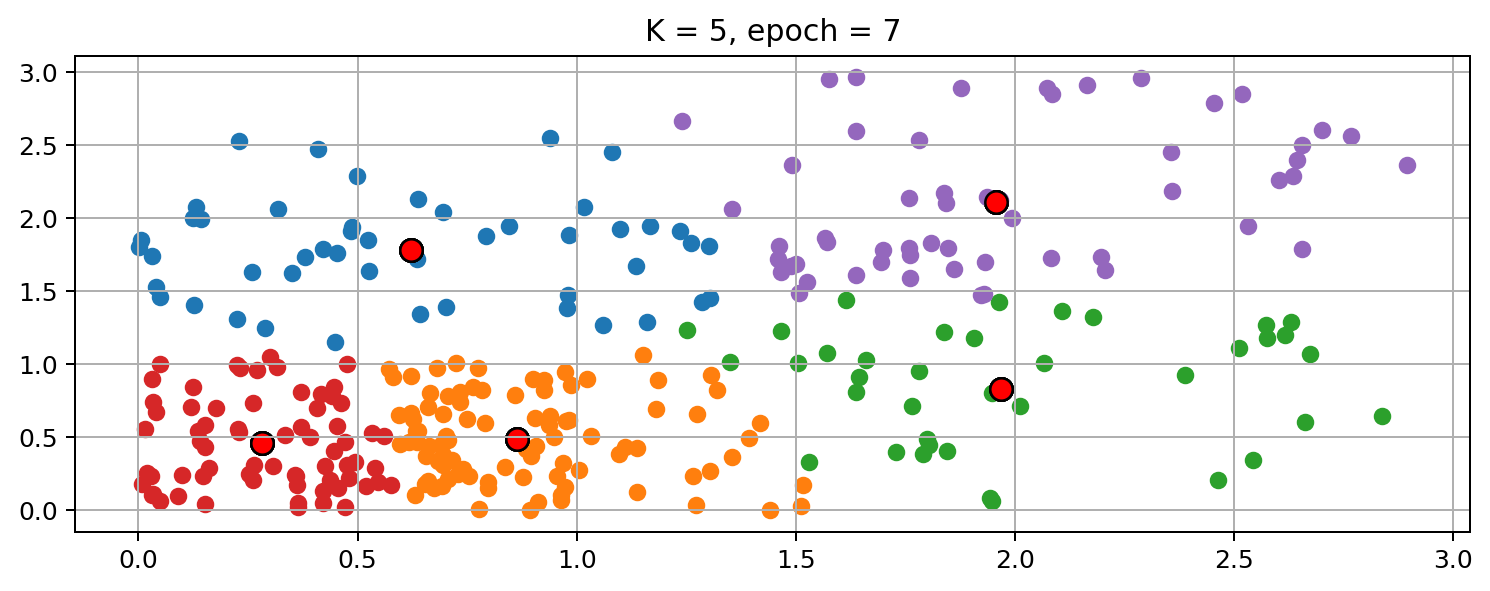

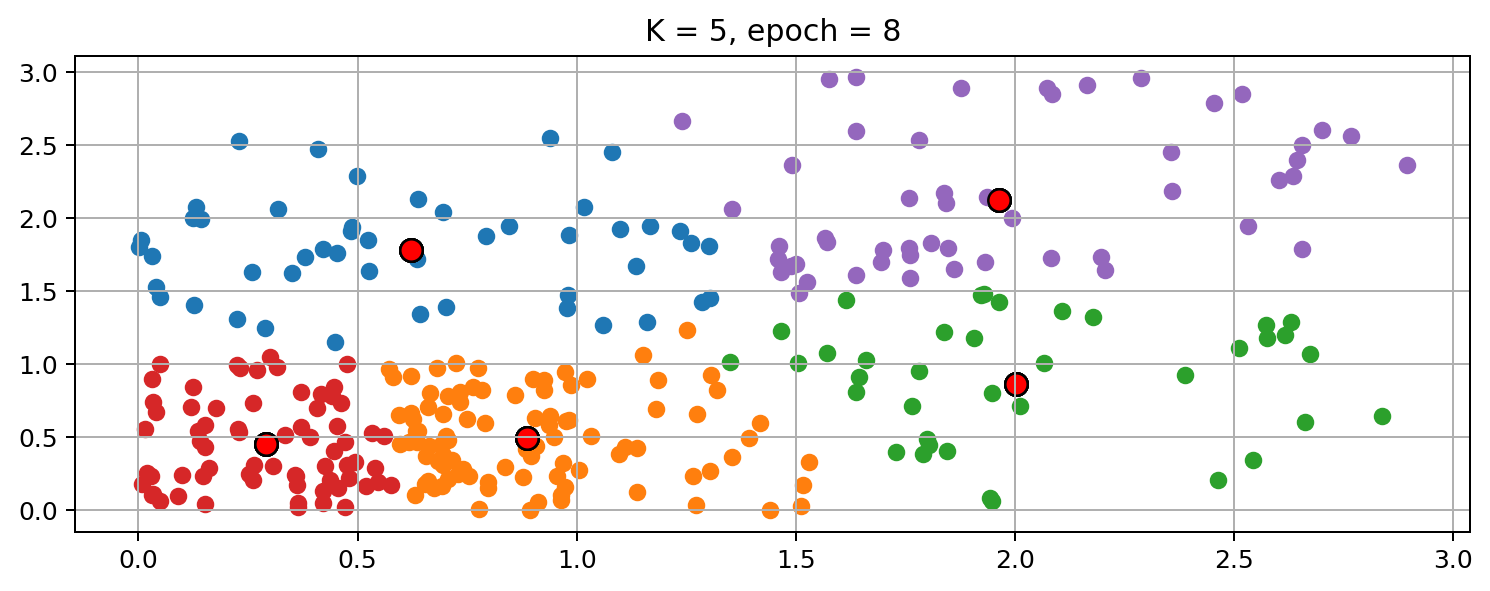

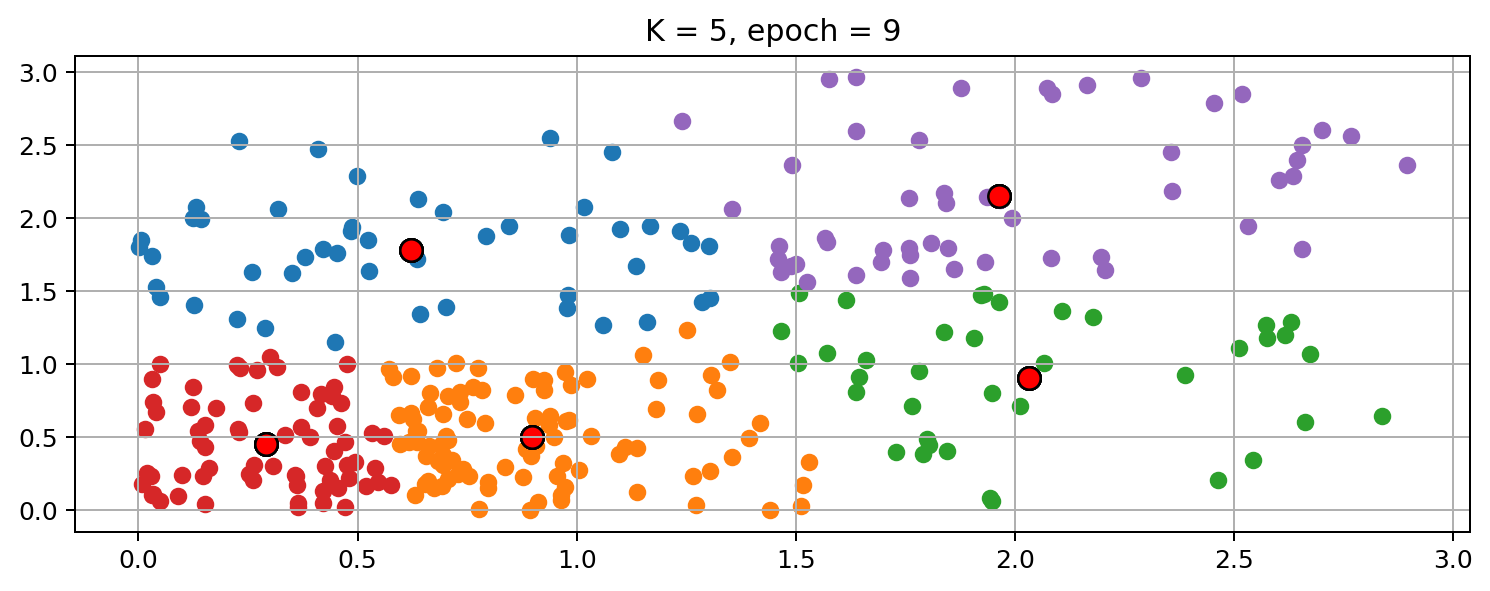

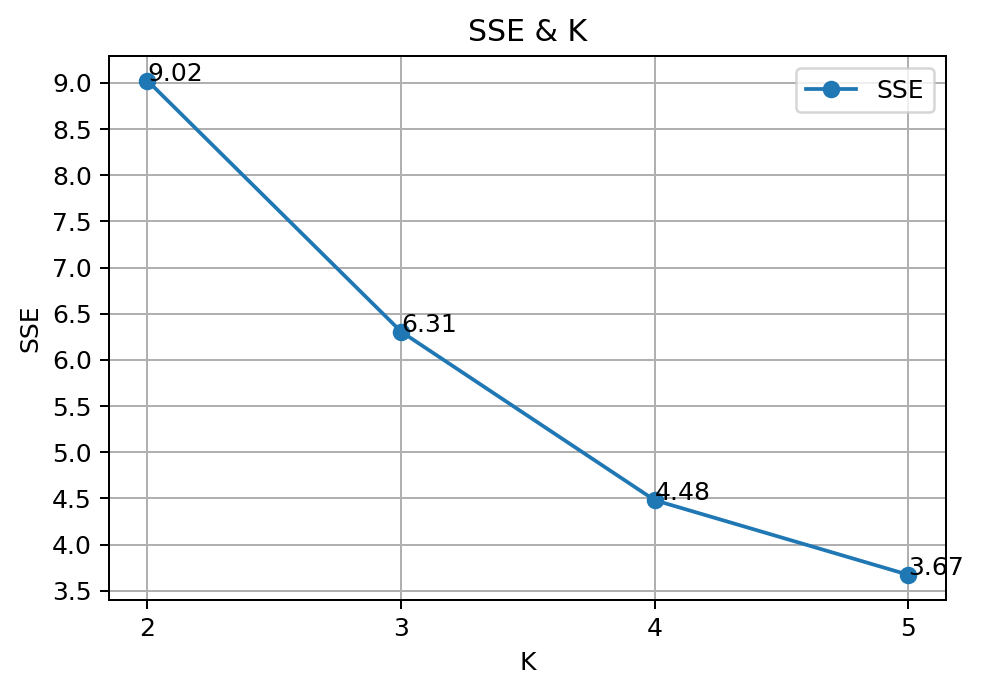

In [82]:
load_data(randomize=True)
kmeans_multiple(K_MIN, K_MAX)